#DATA 620 - FINAL PROJECT

#Amazon Digital Music Review Analysis

**Gillian McGovern, Dhanya Nair, Dirk Hartog**

Understanding Product Influence and Customer Behavior through Co-Purchase
Networks and NLP-Based Product Analysis.

Data Sources: https://amazon-reviews-2023.github.io/

This is a large-scale Amazon Reviews dataset of digital music products, collected in 2023 by McAuley Lab, and it includes rich features such as:

1. User Reviews (ratings, text, helpfulness votes, etc.);
2. Item Metadata (descriptions, price, raw image, etc.);
3. Links (user-item / bought together graphs).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')



## Load Review Data

In [ ]:
# Download ratings dataset
!wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Digital_Music.jsonl.gz
# Item metadata
!wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Digital_Music.jsonl.gz

--2025-07-20 23:14:29--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Digital_Music.jsonl.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26071111 (25M) [application/gzip]
Saving to: ‘Digital_Music.jsonl.gz.2’

Digital_Music.jsonl 100%[===================>]  24.86M  73.7MB/s    in 0.3s    

2025-07-20 23:14:29 (73.7 MB/s) - ‘Digital_Music.jsonl.gz.2’ saved [26071111/26071111]

--2025-07-20 23:14:29--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Digital_Music.jsonl.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13815359 (13M) [application/gzip]
Saving to: ‘meta_Digital_Music.js

In [ ]:
# List the extacted files from the zipped file
!ls

Digital_Music.jsonl.gz	  meta_Digital_Music.jsonl.gz	 sample_data
Digital_Music.jsonl.gz.1  meta_Digital_Music.jsonl.gz.1
Digital_Music.jsonl.gz.2  meta_Digital_Music.jsonl.gz.2


In [ ]:
import gzip
import json

# Assign the file we want to use
file = "Digital_Music.jsonl.gz"

data_list = []
# Reading in text mode (assuming UTF-8 encoding)
with gzip.open(file, 'rt', encoding='utf-8') as f:
  content_text = f.readlines()
  for line in content_text:
    json_data = json.loads(line)
    data_list.append(json_data)


user_reviews = pd.DataFrame(data_list)

user_reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Nice,"If i had a dollar for how many times I have played this cd and how many times I have asked Alexa to play it, I would be rich. Love this singer along with the Black Pumas. Finding a lot of new music that I like a lot on amazon. Try new things.",[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,1618972613292,0,True
1,5.0,Excellent,awesome sound - cant wait to see them in person - always miss them when they are in town !,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,1308167525000,0,True
2,5.0,Great service,This is a great cd. Good music and plays well. Seller responded back very quicky and received it within 3 days,[],B0055JSYHC,B0055JSYHC,AFGEM6BXCYHUILEOA3P2ZYBEF2TA,1615838793006,0,True
3,1.0,No good,"These are not real German singers, they have accents. It is nothing what they advertised it. Music stinks.",[],B000F9SMUQ,B000F9SMUQ,AH3OG6QD6EDJGZRVCFKV4B66VWNQ,1405219741000,0,True
4,3.0,"Cool concept, so-so execution...","I first heard this playing in a Nagoya shop and fell in love with the remix of Ke$ha's ""Tik Tok"" (Ke$ha and Lady Gaga are EVERYWHERE in Japan), which then morphed into several other recent pop hits. When the salesgirl handed me the CD, I was pleased to see that it actually included thirty pop songs by the likes of Lady Gaga, Usher, La Roux, Katy Perry, Black-Eyed Peas, Ke$ha, etc. I researched more after I got home, and discovered that this Japanese label (Manhattan Records) exists solely to put out rerecorded and remixed dance CDs based on recent pop hits, the key word being rerecorded. I guessed as much as I was listening to the CD in-store; several of the soundalikes do a great job, others are just so-so. It's great for workouts, though, since the tracks fade one into another with no downtime (the bad side is that if you've got in in shuffle, the beginning of the next song, which is often in a different key, is kind of an awkward fade-out when not played in sequence).",[],B0049D1WVK,B0049D1WVK,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,1309029595000,0,False


In [ ]:
user_reviews.shape

(130434, 10)

There are **10** features that are included for each review with a total of **130,434** reviews in this data set.

## Load Meta Data

In [ ]:
# List the extacted files from the zipped file
!ls

Digital_Music.jsonl.gz	  meta_Digital_Music.jsonl.gz	 sample_data
Digital_Music.jsonl.gz.1  meta_Digital_Music.jsonl.gz.1
Digital_Music.jsonl.gz.2  meta_Digital_Music.jsonl.gz.2


In [ ]:
# Create a data frame from meta data

meta_data_file = "meta_Digital_Music.jsonl.gz"

meta_data_list = []
# Reading in text mode (assuming UTF-8 encoding)
with gzip.open(meta_data_file, 'rt', encoding='utf-8') as f:
  meta_text = f.readlines()
  for line in meta_text:
    json_meta_data = json.loads(line)
    meta_data_list.append(json_meta_data)


item_meta_data = pd.DataFrame(meta_data_list)

item_meta_data.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,Digital Music,Baja Marimba Band,4.9,8,[],[],NaN,"[{'thumb': 'https://m.media-amazon.com/images/I/51kIbeVPzXL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/51kIbeVPzXL.jpg', 'variant': 'MAIN', 'hi_res': None}, {'thumb': 'https://m.media-amazon.com/images/I/51rWg3aYN4L._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/51rWg3aYN4L.jpg', 'variant': 'PT01', 'hi_res': None}]",[],None,[],"{'Date First Available': 'February 28, 2010'}",B000V87RP2,None
1,Digital Music,'80s Halloween-All Original Artists & Recordings,5.0,3,[],[],14.98,"[{'thumb': 'https://m.media-amazon.com/images/I/01RmK+J4pJL._SS40_.gif', 'large': 'https://m.media-amazon.com/images/I/01RmK+J4pJL.gif', 'variant': 'MAIN', 'hi_res': None}]",[],"Love and Rockets (Artist), Duran Duran (Artist), Ministry (Artist), Echo And The Bunnyman (Artist), Oingo Boingo (Artist), Alice Cooper (Artist), The Sisters Of Mercy (Artist), Joy Division (Artist), Bauhaus (Artist), The Jesus And The Mary (Artist) & 6 more Format: Audio CD",[],"{'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.83 Ounces', 'Manufacturer': 'Somerset', 'Date First Available': 'November 2, 2011', 'Label': 'Somerset', 'Number of discs': '1'}",B0062F0MJQ,None
2,Digital Music,TRIO +1,5.0,1,[],[CD ALBUM],57.99,"[{'thumb': 'https://m.media-amazon.com/images/I/31948GD8JFL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/31948GD8JFL.jpg', 'variant': 'MAIN', 'hi_res': None}]",[],Rob Wasserman Format: Audio CD,[],"{'Is Discontinued By Manufacturer': 'No', 'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.83 Ounces', 'Manufacturer': 'UNIVERSAL VICTOR', 'Date First Available': 'December 28, 2012', 'Label': 'UNIVERSAL VICTOR', 'Number of discs': '1'}",B00005GT12,None
3,Digital Music,"Gold and Silver: Lehar, Delibes, Lanner, Johann Strauss II",5.0,1,[],[],29.91,"[{'thumb': 'https://m.media-amazon.com/images/I/61EYZvzr+4L._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/61EYZvzr+4L.jpg', 'variant': 'MAIN', 'hi_res': 'https://m.media-amazon.com/images/I/81Go3QJNIuL._SL1362_.jpg'}]",[],"Franz Lehar (Composer), Leo Delibes (Composer), Joseph Lanner (Composer), Johann Strauss II (Composer), Janos Sandor (Conductor), Janos Ferencsik (Composer), Budapest Philharmonic Orchestra (Orchestra), Hungarian State Orchestra (Orchestra) & 4 more Format: Audio CD",[],"{'Manufacturer': 'Hungaroton / White Label', 'Date First Available': 'February 4, 2005', 'Label': 'Hungaroton / White Label'}",B0007PD2BW,None
4,Digital Music,"Grateful Dead Dave's Picks Volume 25 Live at Broome County Veteran Memorial Arena Binghamton, NY November 6, 1977",4.9,20,[],[Sold out. Numbered limited edition],149.99,"[{'thumb': 'https://m.media-amazon.com/images/I/61916+eP4iL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/61916+eP4iL.jpg', 'variant': 'MAIN', 'hi_res': 'https://m.media-amazon.com/images/I/91NZl49eUZL._SL1429_.jpg'}, {'thumb': 'https://m.media-amazon.com/images/I/51VfKSSSL3L._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/51VfKSSSL3L.jpg', 'variant': 'PT01', 'hi_res': 'https://m.media-amazon.com/images/I/81xCulmZYGL._SL1366_.jpg'}]",[],"Grateful Dead (Artist, Orchestra) Format: Audio CD",[],"{'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.82 Ounces', 'Manufacturer': 'Dead', 'Date First Available': 'January 27, 2018', 'Label': 'Dead'}",B079CPD45R,None


In [ ]:
item_meta_data.shape

(70537, 14)

### Inspect columns

Some columns in the meta data may not be needed for our analysis. We can inspect the values to assess if they should be dropped.

For columns with a data type of list we need open the lists then check unique values and counts.

In [ ]:
# decription
item_meta_data["description"].explode().value_counts()

,count
description,
CD ALBUM,1241
Product Description,309
CD SINGLE,274
About the Artist,203
Review,182
...,...
"The biggest single of 2020, now headlining the Super Bowl 2021: The Weeknd presents its first “Hits Compilation” 10 years after the first tracks with “The Highlights”. A decade after its very first release, The Weeknd is more successful and omnipresent than ever before: After the record single “Blinding Lights” by the current hit album “After Hours” (2020), he is the first headliner of the legendary Halftime Show at the US Super Bowl. Another knighthood for the Canadian, which now seals the spotlight for the first decade with his brand new compilation “The Highlights”: 18 tracks of the pop mastermind, from the beginnings to the world hits of recent years. Track List: 1. Save Your Tears 2. Blinding Lights 3. In Your Eyes 4. Can't Feel My Face 5. I Feel It Coming (with Daft Punk) 6. Starboy (with Daft Punk) 7. Pray for Me (feat. Kendrick Lamar) 8. Heartless 9. Often 10. The Hills 11. Call Out My Name 12. Die for You 13. Earned It 14. Love Me Harder (feat. Ariana Grande) 15. Acquainted 16. Wicked Games 17. The Morning 18. After Hours",1
"Machine Gun Kelly's fifth studio album, “Tickets to My Downfall,” marks a departure from rap in favor of a pop punk style. Track List: 1. Title Track 2. Kiss Kiss 3. Drunk Face 4. Bloody Valentine 5. Forget Me Too 6. All I Know 7. Lonely 8. WWIII 9. Kevin and Barracuda Interlude 10. Concert for Aliens 11. My Ex's Best Friend 12. Jawbreaker 13. Nothing Inside 14. Banyan Tree Interlude 15. Play This When I'm Gone",1
CD ROM IS IN GREAT CONDITION ! COMES IN ORIGINAL JEWEL CASE I,1


In [ ]:
# features colunm
item_meta_data["features"].explode().value_counts()

,count
features,
lp,6
LP record,3
Your purchase quantity will be count on Korea HANTEO & GAON Chart!,3
All items from original manufacturers are delivered in original sealed package condition.,3
Officially distributed Brand New & Original item from Manufacturer.,3
...,...
Pre-Order Benefit(Autograph Polaroid) is randomly included inside some of the first press albums.,1
"W-3068-LP - The Light and Life Hour Choir - Light & Life Hour Choir, Director L.R. Schoenhals [1960] Soldiers of Christ, Arise/Beside the Still Waters/Jesus Lover of My Soul/Behold the Host/My God Is Real/No One Knows But Jesus/Wonderful Peace/Arise, My Soul, Arise/He Leadeth Me/Great Is Thy Faithfulness/There Is a Fountain/On My Journey Home/When the Shadows Flee away/I Heard the Voice of Jesus Say/Break Thou The Bread of Life/Cleansing Stream",1
"KOTO SHAKUHACHI: A NEW SOUND FROM ""THE JAPANESE BACH SCENE"" ...................THE TRACKS...................... AIR ON THE G STRING MINUET IN G LARGO GAVOTTE I FUGUE NO. 1 TWO-PART INVENTENTION NO. 1 ""LITTLE"" FUGUE IN G MINOR BOURREE MINUET IN G MINOR PRELUDE NO. 2 SICILIANO TWO-PART INVENTION NO. 13",1


In [ ]:
# categories
item_meta_data["categories"].explode().value_counts()

,count
categories,
Digital Music,7
Music By Price,4
$5.00 to $5.99,2
$8.00 to $8.99,2
International Music,1
Far East & Asia,1
Country,1
Rock,1


In [ ]:
# bought_together
item_meta_data["bought_together"].explode().value_counts()

,count
bought_together,


**Columns to drop**

Categories: Small number of categories - unlikely to provide meaningful information

Features: There are 125 unique rows but does not include useful data for our sentiment analysis or network analysis goals

Bought together: A column with of empty lists

Images and the Videos columns are not needed for the purposes of this project

In [ ]:
# Filter out columns that are not needed
## features, images, video, store, categories, bought_together

item_meta_df = item_meta_data[["main_category", "title", "average_rating", "rating_number", "description", "price", "details", "parent_asin"]]

From the meta data we can see that there are 70,537 products that have been reviewed.

The meta data contains the following information:

- title
- average rating
- rating number
- description
- price
- details
- parent_asin

In [ ]:
# Check the parent_asin id's that are in the meta data (products) but have not been reviewed
not_reviewed = set(item_meta_df["parent_asin"]).difference(set(user_reviews["parent_asin"]))
print(len(not_reviewed))

26


There are 26 products that have not been reviewed

In [ ]:
# Products that have not been reviewed

item_meta_df[item_meta_df["parent_asin"].isin(not_reviewed)]

,main_category,title,average_rating,rating_number,description,price,details,parent_asin
4958,Digital Music,SORE DEMO SUKI DA YO(+DVD)(TYPE A),4.3,80,[CD SINGLE],30.55,"{'Is Discontinued By Manufacturer': 'No', 'Product Dimensions': '9.84 x 0.87 x 7.09 inches; 4.16 Ounces', 'Manufacturer': 'AVEX', 'Date First Available': 'May 8, 2012', 'Label': 'AVEX', 'Number of discs': '2'}",B0079RT5XU
5675,Digital Music,SAKURA NO SHIORI(TYPE A)(CD+DVD),4.0,27,[Brand new single from the Japanese idol group produced by Yasushi Akimoto. TYPE A includes a DVD video clip featuring team PB.],24.88,"{'Is Discontinued By Manufacturer': 'No', 'Product Dimensions': '9.84 x 0.87 x 7.09 inches; 4.16 Ounces', 'Date First Available': 'July 18, 2011', 'Number of discs': '1'}",B002XYKB96
10378,Digital Music,Call Of The Valley,4.1,16,[],NaN,"{'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.83 Ounces', 'Date First Available': 'January 3, 2007', 'Number of discs': '1'}",B000LP4Y9C
11209,Digital Music,"Vanessa Amorosi - The Power - Island Records - 159 409-2, Universal Music - 159 409-2",4.2,27,"[1 x CD AlbumGermany 2000, 1 - U R Mine (4:15)2 - Absolutely Everybody (3:42)3 - Shine (3:52)4 - I Wanna Be Your Everything (3:36)5 - How Y' Livin' (4:01)6 - Every Time I Close My Eyes (4:03)7 - Pray For Love (3:34)8 - The Power (3:34)9 - Steam (3:47)10 - Turn To Me (3:36)11 - You Were Led On (4:42)12 - Have A Look (3:34)]",15.79,"{'Is Discontinued By Manufacturer': 'No', 'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.89 Ounces', 'Manufacturer': 'xxx', 'Date First Available': 'November 11, 2008', 'Label': 'xxx', 'Number of discs': '1'}",B0000525QE
12882,Digital Music,Akb48 - Uza (Type-B) (CD+DVD) [Japan LTD CD],4.0,38,[CD SINGLE],14.84,"{'Is Discontinued By Manufacturer': 'No', 'Package Dimensions': '5.75 x 4.96 x 0.39 inches; 4.16 Ounces', 'Manufacturer': 'KING RECORDS (JAPAN)', 'Date First Available': 'October 30, 2012', 'Label': 'KING RECORDS (JAPAN)', 'Number of discs': '2'}",B008Z1E2PU
13741,Digital Music,KOKORO NO HANE(TEAM DRAGON)(CD+DVD)(ltd.ed.),4.2,9,[CD SINGLE],27.78,"{'Is Discontinued By Manufacturer': 'No', 'Package Dimensions': '5.59 x 4.88 x 0.39 inches; 4.16 Ounces', 'Manufacturer': 'COLUMBIA JAPAN', 'Date First Available': 'February 2, 2011', 'Label': 'COLUMBIA JAPAN', 'Number of discs': '2'}",B003OACICQ
13921,Digital Music,1!2!3!4!YOROSHIKU!(CD+DVD)(TYPE B),4.5,26,[CD SINGLE],55.67,"{'Is Discontinued By Manufacturer': 'No', 'Product Dimensions': '11.81 x 3.94 x 7.87 inches; 4.16 Ounces', 'Manufacturer': 'CROWN RECORDS JAPAN', 'Date First Available': 'April 19, 2011', 'Label': 'CROWN RECORDS JAPAN', 'Number of discs': '2'}",B0041669LI
18387,Digital Music,Too Late For Living by Saint (2011-09-13),4.7,28,[],NaN,"{'Date First Available': 'September 22, 2015'}",B013RPVQUC
21664,Digital Music,P.D.Q. Bach: Two Pianos Are Better Than One,4.2,8,"[Peter Schickele, Jon Kimura Parker, The New York Pick-Up Ensemble, Jorge Mester / P.D.Q. Bach: Two Pianos Are Better Than One Label: Telarc Track Title 1. Introduction - Concerto for Two Pianos vs. Orchestra (S. 2 are better than one) 2. Concerto For Two Pianos vs. Orchestra: I. Shake allegro 3. Concerto For Two Pianos vs. Orchestra: II. Andante alighieri 4. Concerto For Two Pianos vs. Orchestra: III. Presto changio 5. Introduction - Trio (sic) Sonata (S. 3(4)) 6. Trio (sic) Sonata: I. Antemezzo 7. Trio (sic) Sonata: II. Mezzo 8. Trio (sic) Sonata: III. Intermezzo 9. Trio (sic) Sonata: IV. I'Altro Mezzo 10. Introduction - Chaconne à son Goût 11. Chaconne à son Goût 12. Introduction - The Musical Sacrifice (S. 50% Off) 13. The Musical Sacrifice: I. Fuga Meshuga 14. The Musical Sacrifice: II. Sort of Little Trio Sonata: Andante; Allegro molto; Lento; Vivace 15. The Musical Sacrifice: III. Three Canons 16. The Musical Sacrifice: IV. Chorale Prelude: 'Da kommt ja der Schurke' 17. The Musical Sacrifice: V. Four More Canons 18. The Musical Sacrifice: VI. The Grossest Fugue 19. Closing]",NaN,"{'Manufacturer': 'Telarc

## Merge Data Frames

In [ ]:
# Merge the review data and meta data on using parent_asin

merged_data = user_reviews.merge(item_meta_df, left_on = "parent_asin", right_on = "parent_asin", suffixes = ("_reviews", "_meta"))

merged_data.head()

,rating,title_reviews,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,title_meta,average_rating,rating_number,description,price,details
0,5.0,Nice,"If i had a dollar for how many times I have played this cd and how many times I have asked Alexa to play it, I would be rich. Love this singer along with the Black Pumas. Finding a lot of new music that I like a lot on amazon. Try new things.",[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,1618972613292,0,True,Digital Music,Good Things,4.5,433,[],17.70,"{'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.82 Ounces', 'Manufacturer': 'Aloe Blacc', 'Date First Available': 'March 12, 2011', 'Label': 'Aloe Blacc', 'Number of discs': '1'}"
1,5.0,Excellent,awesome sound - cant wait to see them in person - always miss them when they are in town !,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,1308167525000,0,True,Digital Music,Sugar Red Drive,5.0,5,[],17.99,"{'Package Dimensions': '5.4 x 4.9 x 0.3 inches; 2.35 Ounces', 'Date First Available': 'April 19, 2009'}"
2,5.0,Great service,This is a great cd. Good music and plays well. Seller responded back very quicky and received it within 3 days,[],B0055JSYHC,B0055JSYHC,AFGEM6BXCYHUILEOA3P2ZYBEF2TA,1615838793006,0,True,Digital Music,Body + Soul: The '70s (Time-Life),4.8,5,[],4.73,{}
3,1.0,No good,"These are not real German singers, they have accents. It is nothing what they advertised it. Music stinks.",[],B000F9SMUQ,B000F9SMUQ,AH3OG6QD6EDJGZRVCFKV4B66VWNQ,1405219741000,0,True,Digital Music,"Aventura, Haiducïï, Kate Ryan, Fanta 4, Laith Al-Deen, Vanilla Ninja, Despina Vandi, DJ Ötzi..",3.2,4,[],2.45,"{'Is Discontinued By Manufacturer': 'No', 'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.82 Ounces', 'Date First Available': 'August 27, 2011', 'Number of discs': '1'}"
4,3.0,"Cool concept, so-so execution...","I first heard this playing in a Nagoya shop and fell in love with the remix of Ke$ha's ""Tik Tok"" (Ke$ha and Lady Gaga are EVERYWHERE in Japan), which then morphed into several other recent pop hits. When the salesgirl handed me the CD, I was pleased to see that it actually included thirty pop songs by the likes of Lady Gaga, Usher, La Roux, Katy Perry, Black-Eyed Peas, Ke$ha, etc. I researched more after I got home, and discovered that this Japanese label (Manhattan Records) exists solely to put out rerecorded and remixed dance CDs based on recent pop hits, the key word being rerecorded. I guessed as much as I was listening to the CD in-store; several of the soundalikes do a great job, others are just so-so. It's great for workouts, though, since the tracks fade one into another with no downtime (the bad side is that if you've got in in shuffle, the beginning of the next song, which is often in a different key, is kind of an awkward fade-out when not played in sequence).",[],B0049D1WVK,B0049D1WVK,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,1309029595000,0,False,Digital Music,GOSSIP PARTY! -THE BEST OF CELEB HITS R&B N HOUSE MIX- MIXED BY DJ D.LOCK,4.5,2,[CD ALBUM],3.88,"{'Is Discontinued By Manufacturer': 'No', 'Package Dimensions': '5.55 x 4.97 x 0.54 inches; 2.83 Ounces', 'Manufacturer': 'INDIE (JAPAN)', 'Date First Available': 'August 8, 2012', 'Label': 'INDIE (JAPAN)', 'Number of discs': '1'}"


In [ ]:
# Print the shape of the merged data
print(merged_data.shape)

# Assess how many unique users

print(merged_data["user_id"].nunique())

# How many unique products are we left with
print(merged_data["parent_asin"].nunique())

(130434, 17)
100952
70511


The average number of reviews a user posted (130,434/100,952 is 1.29 indicating that few users reviewed multiple products.

The average number of reviews for each product is (130,434 / 70,511) is 1.85 indicating that almost all products were reviewed by multiple users.

As stated in our goals, a network analysis will reveal those users that reviewed multiple products and which products were reviewed by multiple users.

Further inspection of the features of our data is needed to understand how they may be useful in the future analysis.

In [ ]:
# Convert the timestamp column into a pandas datetime object

import datetime

def convert_timestamp(timestamp_ms):
  """ Function that takes in a timestamp in milliseconds
  and converts it back to a datetime object"""


  datetime_object = datetime.datetime.fromtimestamp(timestamp_ms / 1000)
  # Divide by 1000 to convert milliseconds to seconds

  return datetime_object

merged_data["timestamp"] = merged_data["timestamp"].apply(convert_timestamp)

# Convert to pandas date time object
merged_data["timestamp"] = pd.to_datetime(merged_data["timestamp"])


In [ ]:
# Create unique identifers for the users
user_dict = {}
unique_users = merged_data["user_id"].unique()

for i in range(len(unique_users)):
  user_dict[unique_users[i]] = i


merged_data["user_index"] = merged_data["user_id"].map(user_dict)

In [ ]:
merged_data["user_id"].value_counts()

,count
user_id,
AGAFM74L2RIJ5O36NNYH4Z5ISQNQ,341
AEDFM4VDH2MKYVBKGYVTU6R5L5FQ,182
AH3FC6V3IUJIN2Y7BCZ7DN3IMMJQ,175
AEFLICXXHRBMNT4HAZH2NUU6TCOA,136
AFMUUMXTKB6C52CCENIFBK4QLT4Q,130
...,...
AHL7DGSMLFV2WWAHFIGP3DZ7RALA,1
AE7CY6ROQ47QXOVVFGJCQTCG3DLQ,1
AGQGE574ILMBA7WG4QZ7PIMIK2RA,1


In [ ]:
# Validate
print(merged_data["user_index"].value_counts().head(1))
print(merged_data["user_id"].value_counts().head(1))
user_dict["AGAFM74L2RIJ5O36NNYH4Z5ISQNQ"]

user_index
27857    341
Name: count, dtype: int64
user_id
AGAFM74L2RIJ5O36NNYH4Z5ISQNQ    341
Name: count, dtype: int64


27857

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130434 entries, 0 to 130433
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             130434 non-null  float64       
 1   title_reviews      130434 non-null  object        
 2   text               130434 non-null  object        
 3   images             130434 non-null  object        
 4   asin               130434 non-null  object        
 5   parent_asin        130434 non-null  object        
 6   user_id            130434 non-null  object        
 7   timestamp          130434 non-null  datetime64[ns]
 8   helpful_vote       130434 non-null  int64         
 9   verified_purchase  130434 non-null  bool          
 10  main_category      130434 non-null  object        
 11  title_meta         130434 non-null  object        
 12  average_rating     130434 non-null  float64       
 13  rating_number      130434 non-null  int64   

### EDA

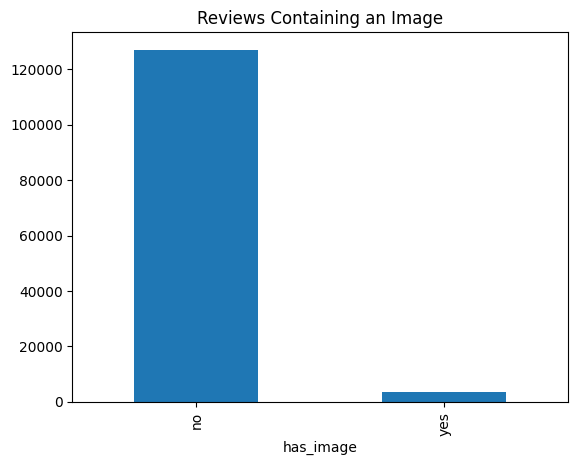

In [ ]:
# Create function that evaluates if an image is attached
def has_image(col):
  if len(col) == 0:
    return "no"
  else:
    return "yes"

merged_data["has_image"] = merged_data["images"].apply(has_image)

merged_data["has_image"].value_counts().plot(kind = "bar")
plt.title("Reviews Containing an Image")
plt.show()

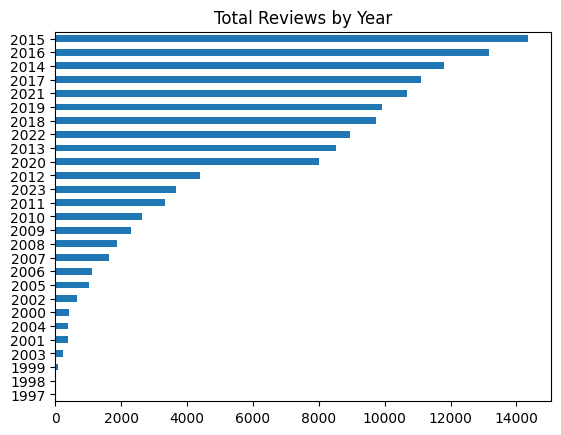

In [ ]:
# Total reveiws by year

merged_data["timestamp"].dt.year.value_counts(ascending = True).plot(kind = "barh")
plt.title("Total Reviews by Year")
plt.ylabel("")
plt.show()

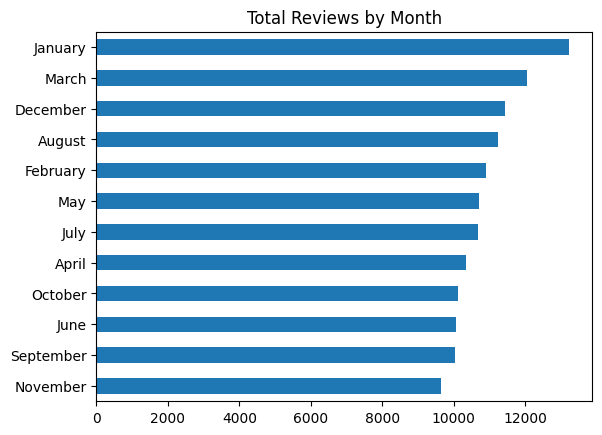

In [ ]:
# Total reviews by month

merged_data["timestamp"].dt.month_name().value_counts(ascending = True).plot(kind = "barh")
plt.title("Total Reviews by Month")
plt.ylabel("")
plt.show()

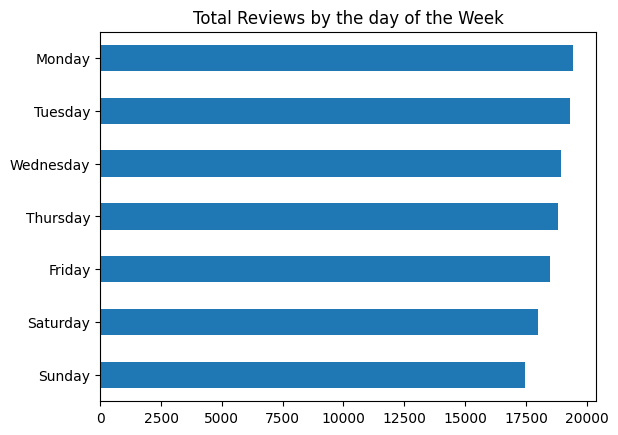

In [ ]:
# Total reviews by day of the week

merged_data["timestamp"].dt.day_name().value_counts(ascending = True).plot(kind = "barh")
plt.title("Total Reviews by the day of the Week")
plt.ylabel("")
plt.show()

Reviews in this data set were created during 1997 - 2023, with the majority posted in 2015.

Samller differneces in the amount of reviews were noted between each weekday and btween eeach month.

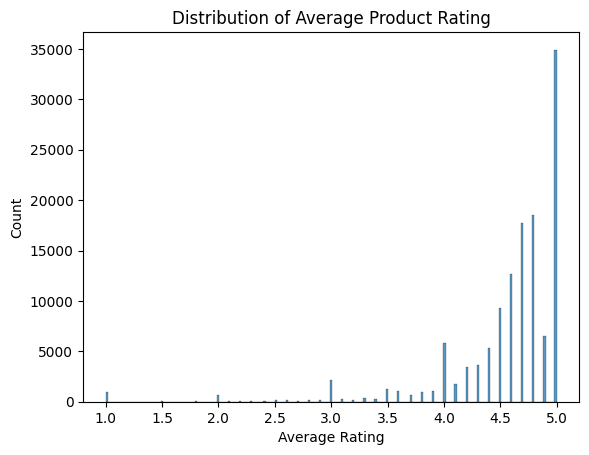

In [ ]:
# Average rating distributions

sns.histplot(merged_data, x = merged_data["average_rating"])
plt.title("Distribution of Average Product Rating")
plt.xlabel("Average Rating")
plt.show()

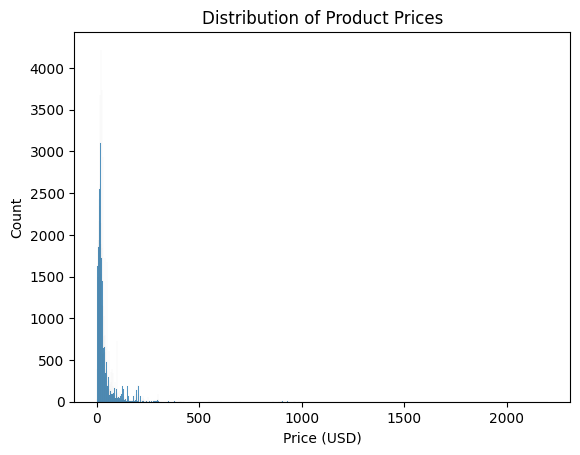

In [ ]:
# Average price distributions

sns.histplot(merged_data, x = "price")
plt.title("Distribution of Product Prices")
plt.xlabel("Price (USD)")
plt.show()

In [ ]:
merged_data["price"].describe()

,price
count,81492.000000
mean,35.668769
std,56.553780
min,0.010000
25%,13.420000
50%,20.990000
75%,36.990000
max,2200.000000


The prices of the products in this data set are heavily right skewed with a range between 0.01 - 2,200 USD.

75% of the products are below $37 dollars.

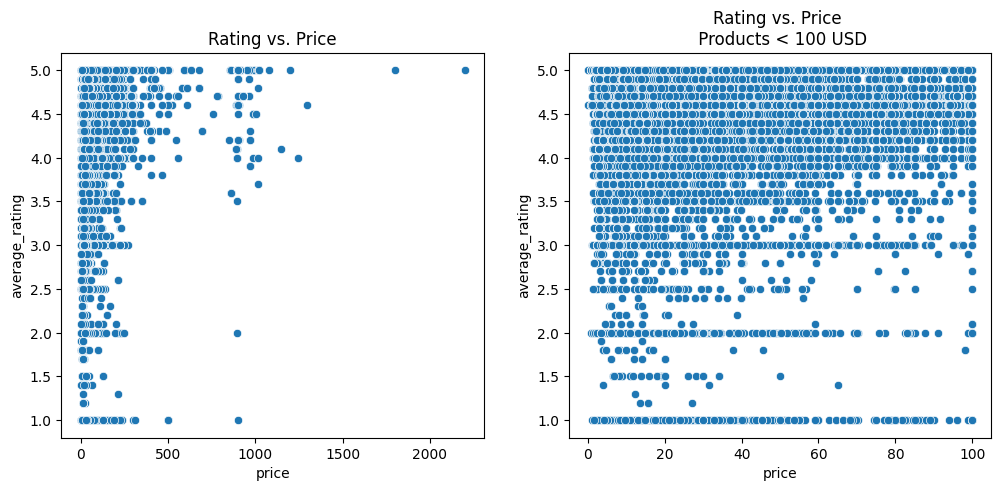

Correlation coefficient between Price and Avg. Rating: 0.001162034113633938


<Figure size 640x480 with 0 Axes>

In [ ]:
# Relationship between price and average rating
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.scatterplot(merged_data, x = "price", y = "average_rating", ax = ax[0])
ax[0].set_title("Rating vs. Price")

sns.scatterplot(merged_data[merged_data["price"] <= 100] , x = "price", y = "average_rating", ax = ax[1])
ax[1].set_title("Rating vs. Price \n Products < 100 USD")
plt.show()

plt.tight_layout()

corr_matirx = merged_data[["price", "average_rating"]].corr()

print(f'Correlation coefficient between Price and Avg. Rating: {corr_matirx.loc["price", "average_rating"]}')

The very low correlation between the price of a product and the average rating suggests price alone has little to no impact how a user rates a product.

In [ ]:
# Descriptive stats for the number of characrters in each review text

review_char_length = [len(txt) for txt in merged_data["text"]]
print(pd.Series(review_char_length).describe())

# Descriptive stats for the number of words in each review
review_word_length = [len(txt) for txt in merged_data["text"].str.split()]
print(pd.Series(review_word_length).describe())

count    130434.000000
mean        340.236280
std         748.095233
min           0.000000
25%          43.000000
50%         124.000000
75%         319.000000
max       24366.000000
dtype: float64
count    130434.000000
mean         59.554472
std         125.398350
min           0.000000
25%           8.000000
50%          23.000000
75%          58.000000
max        4187.000000
dtype: float64


## Final Data Key

The final data set contains the following features, denoted ny where the data came from (user_review or item_meta_data)

Rating (user_reviews)
- Rating of the product (from 1.0 to 5.0).

title_reviews (user_reviews)
- Title of the user review.

text (user_review)
- Text body of the user review.

images (user_review)
- Images that users post after they have received the product.

asin (user_review)
- ID of the product.

parent_asin (user_review)
- Parent ID of the product. **This was used to find product meta data**

user_id (user_review)
- ID of the reviewer

timestamp (user_review)
- Time of the review converted to pandas dattime object

helpful_vote (user_review)
- Helpful votes of the review

verified_purchase (user_review)
- User purchase verification

main_category (item_meta_data)
- Main category (i.e., domain) of the product.

title_meta (item_meta_data)
- Name of the product.

average_rating (item_meta_data)
- Rating of the product shown on the product page.

rating_number (item_meta_data)
- Number of ratings in the product.

description (item_meta_data)
- Description of the product.

price (item_meta_data)
- Price in US dollars (at time of crawling).

details (item_meta_data)
- Product details, including materials, brand, sizes, etc.

has_image (user_review)
- Yes/No value if the user posted an image or not






### Network Analysis

In [ ]:
network_df = merged_data[["user_index", "title_meta", "rating", "timestamp"]]
# Too much data to include all of the years, so let's only look at recent reviews (2015 and later)
network_df_filtered = network_df[network_df['timestamp'].dt.year >= 2015]
# network_df_filtered = network_df


# Check for multiple ratings for a single product by a single user
users_and_titles = network_df_filtered[['user_index', 'title_meta']]
display(users_and_titles[users_and_titles.duplicated(keep=False)])

,user_index,title_meta
1340,1016,Backtracks Collectors
1341,1016,Backtracks Collectors
2817,2077,Trouble Man: Expanded Edition by Marvin Gaye [2012] Audio CD
2820,2077,Trouble Man: Expanded Edition by Marvin Gaye [2012] Audio CD
2838,2090,Peaceful Christmas - 2 CD Collection
...,...,...
130141,100685,Ddu-Du Ddu-Du
130150,100694,Stars Dance (Deluxe Edition CD & DVD)
130151,100694,Stars Dance (Deluxe Edition CD & DVD)
130382,100904,"Enhypen - Border : Carnival [Hype ver.] [Pre Order] CD+Photobook+Folded Poster+Others with Tracking, Extra Decorative Stickers, Photocards"


In [ ]:
# If there are duplicate ratings, just take the mean of the duplicates
network_df_avg = network_df_filtered.groupby(['user_index', 'title_meta']).mean().reset_index()

In [ ]:
# Create graph
G = nx.Graph()

# Add nodes from the df - identify bipartite attribute
G.add_nodes_from(network_df_avg["user_index"], bipartite='user', color="#9ea1d8")
G.add_nodes_from(network_df_avg["title_meta"], bipartite='product', color="#ffa500")

# Add edges with rating as weight attribute
for r, d in network_df_avg.iterrows():
    G.add_edge(d['user_index'], d['title_meta'], weight=d['rating'])

In [ ]:
# Check if connected
print('Is the graph connected?', nx.is_connected(G))
# Check if bipartite graph
print('Is the graph bipartite?', bipartite.is_bipartite(G))

Is the graph connected? False
Is the graph bipartite? True


This graph is bipartite but not full connected, so let's use the largest subgraph.

In [ ]:
# Find the largest connected component(LCC)

lcc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc).copy()

In [ ]:
# Takes a while
# Compute Diameter :Longest shortest path in the largest connected part
# diameter = nx.diameter(G_lcc)
# print(f"Diameter: {diameter}")

In [ ]:
# Check if connected
print('Is the graph connected?', nx.is_connected(G_lcc))
# Check if bipartite graph
print('Is the graph bipartite?', bipartite.is_bipartite(G_lcc))

Is the graph connected? True
Is the graph bipartite? True


In [ ]:
# Get the user and album nodes
users = [n for n, d in G_lcc.nodes(data=True) if d['bipartite'] == 'user']
products = [n for n, d in G_lcc.nodes(data=True) if d['bipartite'] == 'product']

In [ ]:
# Exploratory data analysis
# Get the number of nodes and edges
print(f'There are {len(users)} user nodes, {len(products)} product nodes and {len(G_lcc.edges())} edges (ratings) in this data set')

There are 19525 user nodes, 7390 product nodes and 28122 edges (ratings) in this data set


In [ ]:
# Create unipartite projections from bipartite

# ratings are the weight so use weighted_projected_graph
G_weighted_users = nx.bipartite.weighted_projected_graph(G_lcc, nodes=users)
G_weighted_products = nx.bipartite.weighted_projected_graph(G_lcc, nodes=products)

### Visualizing Networks

#### Users

In [ ]:
# This takes too long to run - it mainly looks like a blob anyway
# We could narrow down the data to allow this to run if we want

# Plot the users network
# pos = nx.spring_layout(G_weighted_users, seed=648)  # Seed layout for reproducible node positions
# nx.draw(G_weighted_users, pos)
# plt.show()

#### Trimming the Network: Island Method

In [ ]:
# Island method for reducing users
# Code from the textbook
def trim_edges(g, weight=1):
  g2=nx.Graph()
  for f, to, edata in g.edges(data=True):
    if edata['weight'] > weight:
      g2.add_edge(f,to, weight=edata['weight'])
  return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

cc = list(G_weighted_users.subgraph(c) for c in nx.connected_components(G_weighted_users))[0]
islands=island_method(cc, 2)
print("Island Method for Users:")
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    # print (i[0], len(i[1]), len(nx.connected_component_subgraphs(i[1])))
    connected_components = list(i[1].subgraph(c) for c in nx.connected_components(i[1]))
    print (f"threshold level: {i[0]}, size of the graph: {len(i[1])}, number of connected components {len(connected_components)}")

Island Method for Users:
threshold level: 1, size of the graph: 498, number of connected components 138
threshold level: 5, size of the graph: 7, number of connected components 3
threshold level: 9, size of the graph: 2, number of connected components 1


<Figure size 1000x600 with 0 Axes>

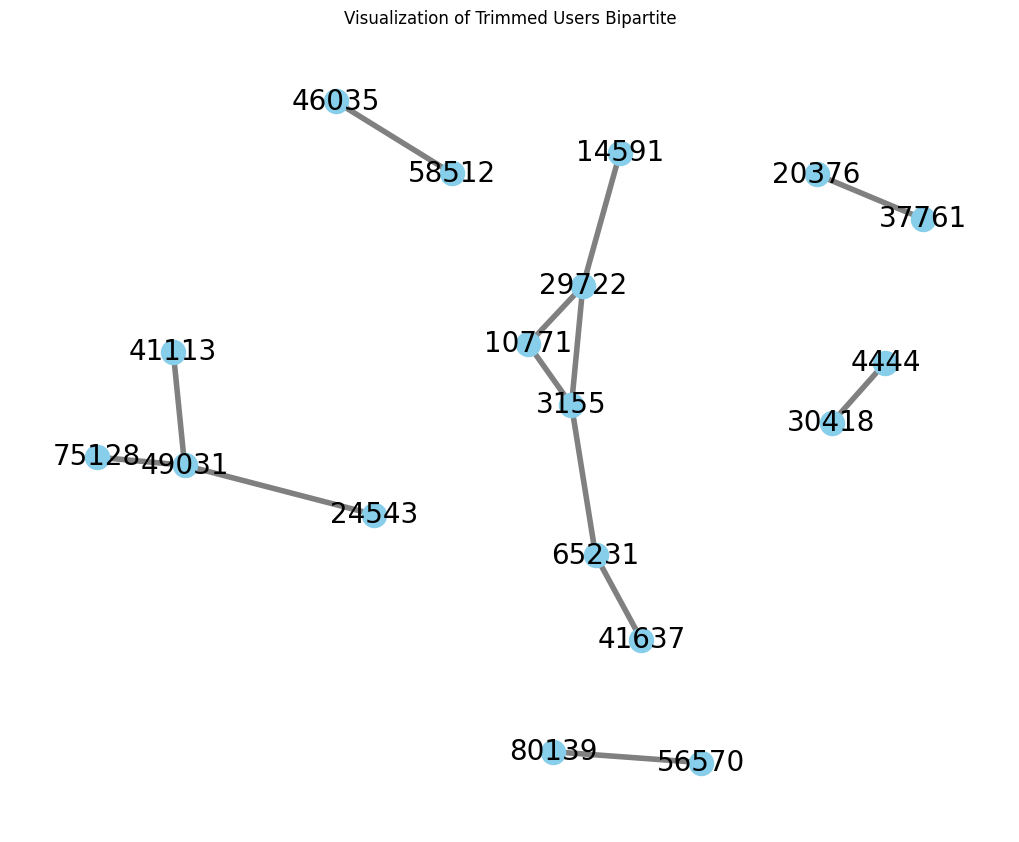

In [ ]:
# Plot trimmed users

users_trimmed = trim_edges(G_weighted_users, 3)


plt.figure(1,figsize=(10,6))
pos = nx.spring_layout(users_trimmed, seed=748, k=1)  # Seed layout for reproducible node positions
plt.figure(figsize=(10, 8))
nx.draw(
    users_trimmed,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=300,
    font_size=20,
    width= 4
)
plt.title("Visualization of Trimmed Users Bipartite")
plt.show()

In [ ]:
# Users centrality metrics of trimmed graph

users_centrality_trimmed = pd.DataFrame({
     "Degree": nx.degree_centrality(users_trimmed),
     "Weighted Degree": dict(users_trimmed.degree(weight='weight')),
     "Betweenness": nx.betweenness_centrality(users_trimmed, weight='weight'),
     "Closeness": nx.closeness_centrality(users_trimmed),
     "Eigenvector": nx.eigenvector_centrality(users_trimmed)
 })

users_centrality_trimmed.sort_values(by='Weighted Degree', ascending=False).head(10)

,Degree,Weighted Degree,Betweenness,Closeness,Eigenvector
3155,0.176471,19,0.044118,0.210084,5.641292e-01
49031,0.176471,18,0.022059,0.176471,2.882647e-05
29722,0.176471,17,0.029412,0.183824,5.454325e-01
10771,0.117647,16,0.000000,0.163399,4.753498e-01
65231,0.117647,11,0.029412,0.163399,2.960083e-01
75128,0.058824,10,0.000000,0.105882,1.664297e-05
41637,0.058824,7,0.000000,0.113122,1.268136e-01
4444,0.058824,5,0.000000,0.058824,3.559541e-12
30418,0.058824,5,0.000000,0.058824,3.559541e-12
14591,0.058824,4,0.000000,0.122549,2.336700e-01


Community 1: [3155, 10771, 14591, 29722]
Community 2: [24543, 41113, 49031, 75128]
Community 3: [41637, 65231]
Community 4: [4444, 30418]
Community 5: [20376, 37761]
Community 6: [46035, 58512]
Community 7: [56570, 80139]


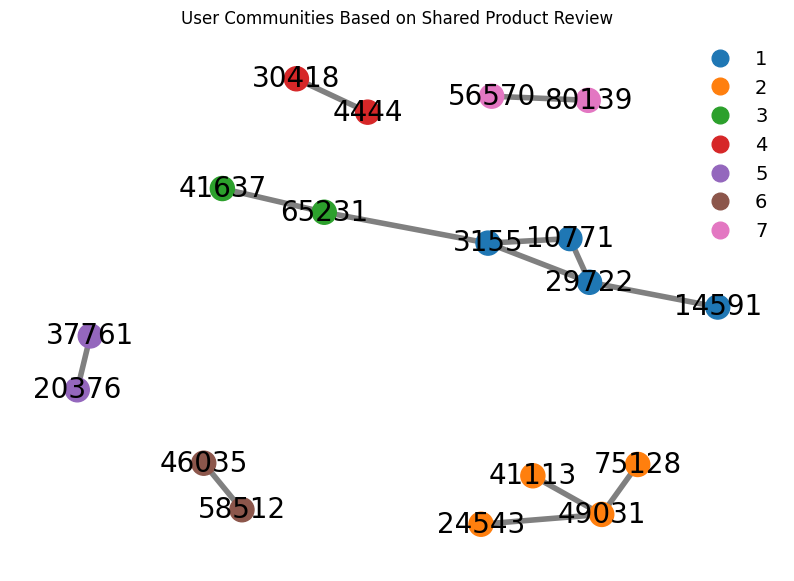

In [ ]:
#  Detect user communities
#  Use the trimmed subgraph - users_trimmed

from networkx.algorithms.community import greedy_modularity_communities

user_communities = list(greedy_modularity_communities(users_trimmed))

# Print each community
for i, group in enumerate(user_communities):
  print(f"Community {i+1}: {sorted(group)}")

# Assign colors to each community
user_community_colors = {}
community_colors = {}
color_palette = plt.cm.tab10.colors  # Up to 10 distinct colors

for i, comm in enumerate(user_communities):
  community_colors[i+1] = color_palette[i]
  for user in comm:
    user_community_colors[user] = color_palette[i]

# Draw the graph
pos = nx.spring_layout(users_trimmed, seed=42, k=1)
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(users_trimmed, pos,
                        node_color=[user_community_colors[n] for n in users_trimmed.nodes()],
                        node_size=300)
nx.draw_networkx_edges(users_trimmed, pos, width=4, edge_color='gray')
nx.draw_networkx_labels(users_trimmed, pos, font_size=20)
plt.title("User Communities Based on Shared Product Review")
plt.axis('off')

import matplotlib.lines as mlines

legend_elements = []
for key, value in community_colors.items():
    legend_elements.append(mlines.Line2D([], [], color=value, marker='o',
                                         linestyle='None', label=key))

# Create legend
plt.legend(handles=legend_elements,
           loc='upper right',
           markerscale = 2,
           fontsize  = 14,
           frameon = False)

plt.show()

In [ ]:
# Explore the characteristics of each community

for i, u_comm in enumerate(user_communities):
  # gbo = merged_data[merged_data["title_meta"].isin(product_comm)].groupby("description")
  pd.set_option('display.max_colwidth', None)
  gbo = merged_data[merged_data["user_index"].isin(u_comm)].groupby(["title_reviews"])
  # gbo['description'] = str(gbo['description'])
  print(f'USER COMMUNITY {i+1}:')
  print(gbo.agg(title_reviews_counts = ("title_reviews", "count"),
                avg_Rating = ("rating", "mean")).sort_values("title_reviews_counts",
                                                             ascending = False).head(3))

  print("\n~~~~~~~~~~~~~~~~")

USER COMMUNITY 1:
                           title_reviews_counts  avg_Rating
title_reviews                                              
Five Stars                                   30         5.0
Just What I Needed                            5         5.0
1964 - A Very Good Year!!                     1         5.0

~~~~~~~~~~~~~~~~
USER COMMUNITY 2:
                                                                                          title_reviews_counts  \
title_reviews                                                                                                    
Five Stars                                                                                                  40   
only with this CD did I finally find what I was looking for—all tracks in good sound! So                    28   
Three Stars                                                                                                  7   

                                                                           

Overall each user community has a high average rating (which makes sense based off of our EDA where product ratings are skewed higher). Top users have similar co purchasing behavior.

#### Finding Similar Users - Recommendations

In [ ]:
def find_shared_nodes_within_group(G, node1, node2):
    '''
    Returns a list of shared neighbors between node1 and node2 (node1 and node2 must be part of the same group)
    '''
    # Nodes must be part of the same group
    assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite'], "Nodes must be under the same group"

    # Grab neighbors of node 1
    node1_neighbors = G.neighbors(node1)
    # Grab neighbors of node 2
    node2_neighbors = G.neighbors(node2)

    # Find intersection
    shared_nodes = set(node1_neighbors).intersection(node2_neighbors)
    return shared_nodes

# Find the shared albums between user 1 and user 2

find_shared_nodes_within_group(G, 3155, 10771)

{'ProdName',
 "Singers and Songwriters Mid 70's",
 'Singers and Songwriters: The 1960s',
 'Sounds Of The Seventies - 1971',
 'Sounds of the Seventies - 1971: Take Two',
 'Sounds of the Seventies: 1975',
 'Sounds of the Seventies: 1979',
 'The Singers and Songwriters Collection: The Classics',
 'Time Life Sounds of the Seventies: 1973'}

In [ ]:
def find_user_similarity_score(G, node1, node2):
    '''
    Returns the similarity score between node1 (user1) and node2 (user2) by
    finding the fraction of shared products
    '''
    # Nodes must be part of the same group
    assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite'], "Nodes must be under the same group"

    # Grab the shared nodes
    shared_nodes = find_shared_nodes_within_group(G, node1, node2)

    # Find percentage of product nodes that are shared
    return len(shared_nodes) / len(products)

In [ ]:
def find_most_similar_users(G, user):
    '''
    Returns the most similar users for a given user
    '''
    # Must be user node
    assert G.nodes[user]['bipartite'] == "user", "Node must be part of the user group"

    # Remove the user
    users2=users.copy()
    users2.remove(user)

    similarities = defaultdict(list)
    for u in users2:
        similarity_score = find_user_similarity_score(G, user, u)
        similarities[similarity_score].append(u)

    # Find the maximum similarity
    max_similarity = max(similarities.keys())

    # Return list of users that share maximal similarity
    return similarities[max_similarity][:5]

# Find the most similar users to 3155
print(find_most_similar_users(G, 3155))

[10771]


In [ ]:
# Find products from the most similar user that this user has not rated
products_from_most_similar_user = dict(sorted(dict(G[10771]).items(), key=lambda item: item[1]['weight'], reverse = True))
products_from_original_user = dict(sorted(dict(G[3155]).items(), key=lambda item: item[1]['weight'], reverse = True))
unique_product_list = list(set(products_from_most_similar_user.keys()) - set(products_from_original_user.keys()))
unique_product_list

['Sounds of the Seventies The Late 70s',
 'Singers and Songwriters: 1975 - 1979',
 'Singers & Songwriters: Classics',
 'Singers and Songwriters: 1976-1977',
 'Singers and Songwriters: 1972-1973',
 'Time Life Singers and Songwriters 1978-1979']

### Products

In [ ]:
# Island method for reducing products
cc_products = list(G_weighted_products.subgraph(c) for c in nx.connected_components(G_weighted_products))[0]
islands_products =island_method(cc_products, 3)
print("Island Method for Products:")
for i in islands_products:
    # print the threshold level, size of the graph, and number of connected components
    # print (i[0], len(i[1]), len(nx.connected_component_subgraphs(i[1])))
    connected_components = list(i[1].subgraph(c) for c in nx.connected_components(i[1]))
    print (f"threshold level: {i[0]}, size of the graph: {len(i[1])}, number of connected components {len(connected_components)}")

Island Method for Products:
threshold level: 1, size of the graph: 418, number of connected components 118
threshold level: 8, size of the graph: 4, number of connected components 2
threshold level: 15, size of the graph: 2, number of connected components 1
threshold level: 22, size of the graph: 2, number of connected components 1


<Figure size 1000x600 with 0 Axes>

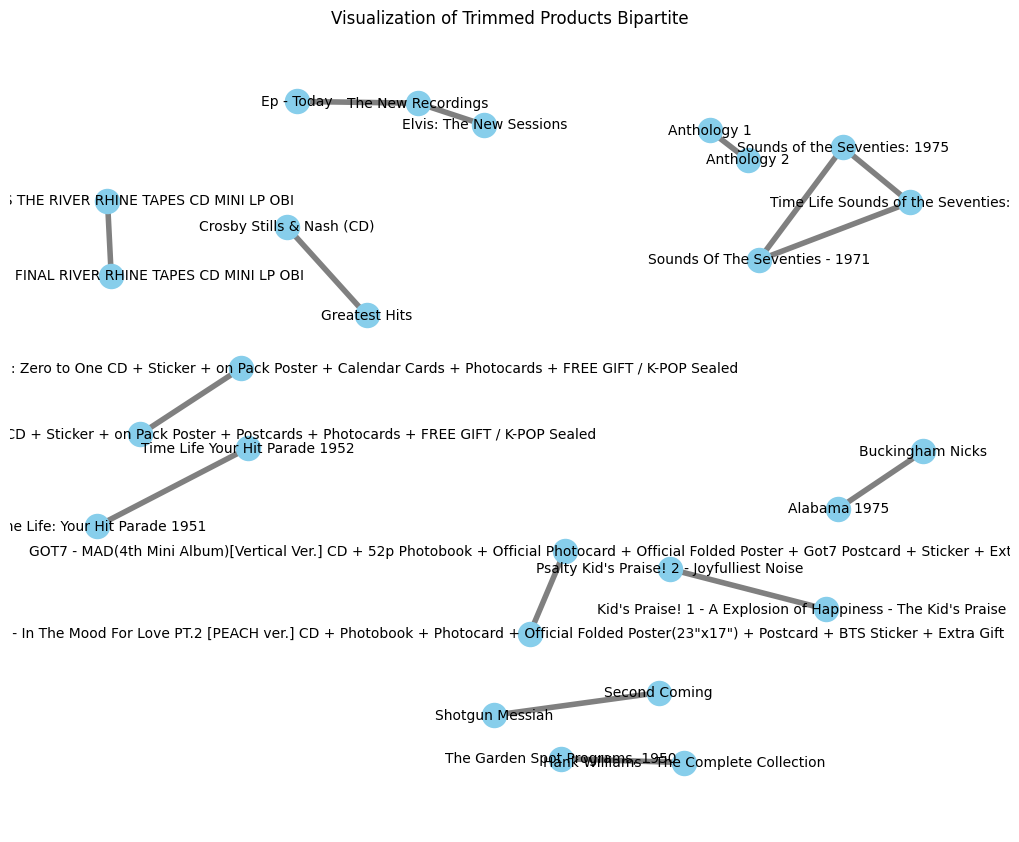

In [ ]:
# Plot trimmed products

# Choose weight 3
products_trimmed = trim_edges(G_weighted_products, 3)


plt.figure(1,figsize=(10,6))
pos = nx.spring_layout(products_trimmed, seed=748, k=1)  # Seed layout for reproducible node positions
plt.figure(figsize=(10, 8))
nx.draw(
    products_trimmed,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=300,
    font_size=10,
    width= 4
)
plt.title("Visualization of Trimmed Products Bipartite")
plt.show()

We can see all these "islands" of products make sense. Most of these albums consist of a part 1 and part 2 such `The Anthology 1` and `The Anthology 2`. Most customers who want to buy part 1 of an album series, would logically want to buy part 2 as well. A lot of these albums involve the greatest hits of an artist which makes sense they would have enough reviews to create their own cluster.

In [ ]:
# Users centrality metrics of trimmed graph

products_centrality_trimmed = pd.DataFrame({
     "Degree": nx.degree_centrality(products_trimmed),
     "Weighted Degree": dict(products_trimmed.degree(weight='weight')),
     "Betweenness": nx.betweenness_centrality(products_trimmed, weight='weight'),
     "Closeness": nx.closeness_centrality(products_trimmed),
     "Eigenvector": nx.eigenvector_centrality(products_trimmed)
 })

products_centrality_trimmed.sort_values(by='Weighted Degree', ascending=False).head(20)

,Degree,Weighted Degree,Betweenness,Closeness,Eigenvector
Anthology 1,0.04,24,0.000000,0.040000,6.875950e-09
Anthology 2,0.04,24,0.000000,0.040000,6.875950e-09
The New Recordings,0.08,19,0.003333,0.080000,3.959446e-05
Elvis: The New Sessions,0.04,15,0.000000,0.053333,2.799751e-05
Sounds Of The Seventies - 1971,0.08,9,0.000000,0.080000,5.773503e-01
Time Life Sounds of the Seventies: 1973,0.08,9,0.000000,0.080000,5.773503e-01
Sounds of the Seventies: 1975,0.08,8,0.000000,0.080000,5.773503e-01
THE BEATLES FINAL RIVER RHINE TAPES CD MINI LP OBI,0.04,6,0.000000,0.040000,6.875950e-09
THE BEATLES THE RIVER RHINE TAPES CD MINI LP OBI,0.04,6,0.000000,0.040000,6.875950e-09
"BTS - In The Mood For Love PT.2 [PEACH ver.] CD + Photobook + Photocard + Official Folded Poster(23""x17"") + Postcard + BTS Sticker + Extra Gift Photocard",0.04,5,0.000000,0.040000,6.875950e-09


Again, it makes sense the products with the highest weighted degree centrality would be `The Anthology 1` and `The Anthology 2` as they are both from The Beatles. It is interesting as this has not only older artists, but also newer ones such as BTS. For the newer artists, these products consist of a bundle of items from different K-POP artists, meaning for customers purchasing these products, they are more likey to buy similar items (such as a bundle), for different artists in the same genre.

`Sounds Of The Seventies` has a high eigenvector score which means this album is connected to other influential albums. This is not surprising as this album consists of a wide range of artists, encapsulating music of an entire decade.

Community 1: ['Sounds Of The Seventies - 1971', 'Sounds of the Seventies: 1975', 'Time Life Sounds of the Seventies: 1973']
Community 2: ['Elvis: The New Sessions', 'Ep - Today', 'The New Recordings']
Community 3: ["Kid's Praise! 1 - A Explosion of Happiness - The Kid's Praise Album", "Psalty Kid's Praise! 2 - Joyfulliest Noise"]
Community 4: ['THE BEATLES FINAL RIVER RHINE TAPES CD MINI LP OBI', 'THE BEATLES THE RIVER RHINE TAPES CD MINI LP OBI']
Community 5: ['Anthology 1', 'Anthology 2']
Community 6: ['Second Coming', 'Shotgun Messiah']
Community 7: ['BTS - In The Mood For Love PT.2 [PEACH ver.] CD + Photobook + Photocard + Official Folded Poster(23"x17") + Postcard + BTS Sticker + Extra Gift Photocard', 'GOT7 - MAD(4th Mini Album)[Vertical Ver.] CD + 52p Photobook + Official Photocard + Official Folded Poster + Got7 Postcard + Sticker + Extra Photocard']
Community 8: ['Hank Williams - The Complete Collection', 'The Garden Spot Programs, 1950']
Community 9: ['Crosby Stills & Nash (C

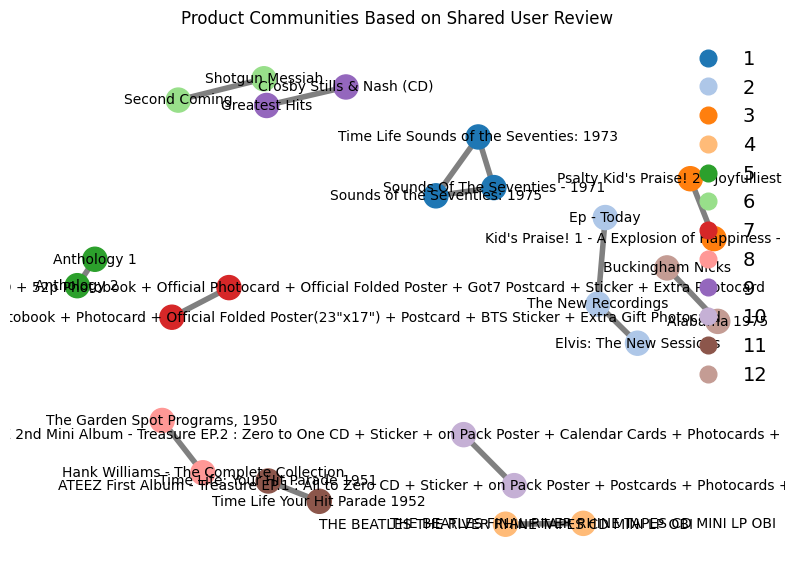

In [ ]:
# Find product communities

from networkx.algorithms.community import greedy_modularity_communities

product_communities = list(greedy_modularity_communities(products_trimmed))

# # Print each community
for i, group in enumerate(product_communities):
  print(f"Community {i+1}: {sorted(group)}")

# Assign colors to each community
product_community_colors = {}
product_comm_colors = {}
color_palette = plt.cm.tab20.colors  # Up to 20 distinct colors

for i, comm in enumerate(product_communities):
  product_comm_colors[i+1] = color_palette[i]
  for album in comm:
    product_community_colors[album] = color_palette[i]

# Draw the graph
pos = nx.spring_layout(products_trimmed, seed=4, k=1)
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(products_trimmed, pos,
                        node_color=[product_community_colors[n] for n in products_trimmed.nodes()],
                        node_size=300)
nx.draw_networkx_edges(products_trimmed, pos, width=4, edge_color='gray')
nx.draw_networkx_labels(products_trimmed, pos, font_size=10)
plt.title("Product Communities Based on Shared User Review")
plt.axis('off')

import matplotlib.lines as mlines

legend_elements = []
for key, value in product_comm_colors.items():
    legend_elements.append(mlines.Line2D([], [], color=value, marker='o',
                                         linestyle='None', label=key))

# Create legend
plt.legend(handles=legend_elements,
           loc='upper right',
           markerscale = 2,
           fontsize  = 14,
           frameon = False)


plt.show()

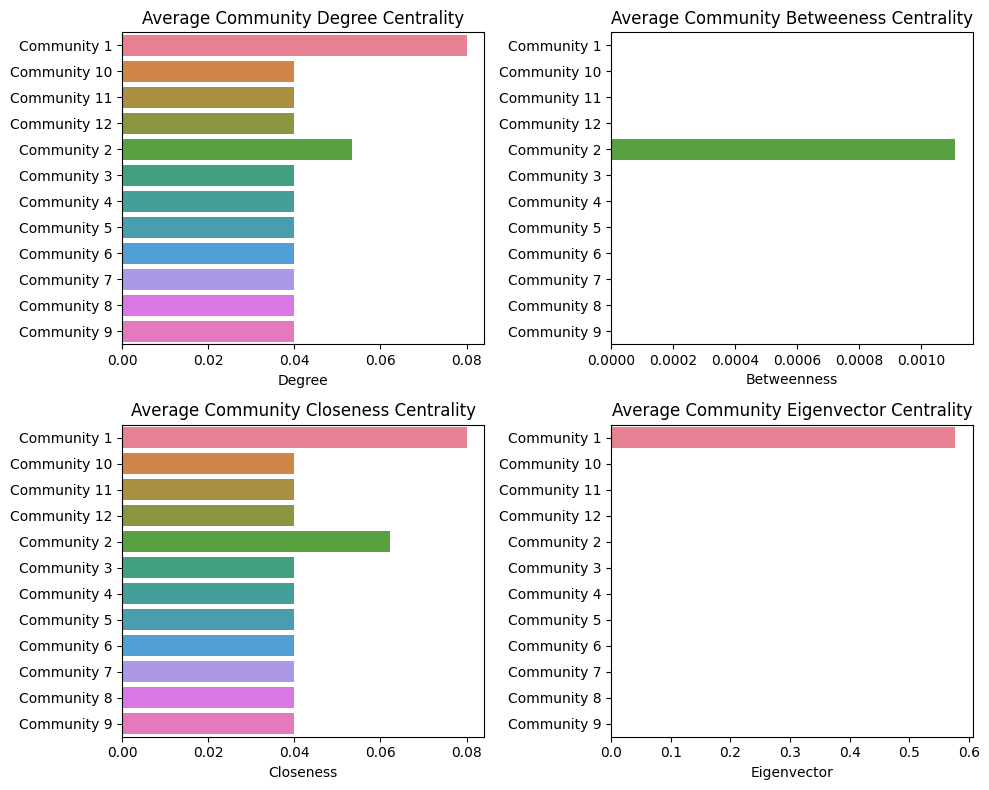

In [ ]:
# Find average centrality measures within the communities


# Assign a label to each node
prod_communities_dict = {}

for i, p_comm in enumerate(product_communities):
  for node in p_comm:
    prod_communities_dict[node] = f'Community {i+1}'


products_centrality_trimmed_copy =  products_centrality_trimmed.copy()

products_centrality_trimmed_copy["title_meta"] = products_centrality_trimmed_copy.index

products_centrality_trimmed_copy["Community"] =  products_centrality_trimmed_copy["title_meta"].map(prod_communities_dict)

aver_community_centrality = products_centrality_trimmed_copy.groupby("Community", as_index = False).agg({'Degree': 'mean',
                                                         'Weighted Degree': 'mean',
                                                         'Betweenness' : 'mean',
                                                         'Closeness' :'mean',
                                                         'Eigenvector' : 'mean'
                                                         })

aver_community_centrality

# Visualize average centrality measures
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

sns.barplot(data = aver_community_centrality, x = "Degree", y = "Community",
            hue = "Community", ax = ax[0][0])
ax[0][0].set_title("Average Community Degree Centrality")
ax[0][0].set_ylabel("")

sns.barplot(data = aver_community_centrality, x = "Betweenness", y = "Community",
            hue = "Community", ax = ax[0][1])
ax[0][1].set_title("Average Community Betweeness Centrality")
ax[0][1].set_ylabel("")

sns.barplot(data = aver_community_centrality, x = "Closeness", y = "Community",
            hue = "Community",ax = ax[1][0])
ax[1][0].set_title("Average Community Closeness Centrality")
ax[1][0].set_ylabel("")

sns.barplot(data = aver_community_centrality, x = "Eigenvector", y = "Community",
            hue = "Community", ax = ax[1][1])
ax[1][1].set_title("Average Community Eigenvector Centrality")
ax[1][1].set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
# Explore the descriptions for each community of products

for i, product_comm in enumerate(product_communities):
  # gbo = merged_data[merged_data["title_meta"].isin(product_comm)].groupby("description")
  pd.set_option('display.max_colwidth', None)
  merged_data['description_string'] = merged_data['description'].str.join(', ')
  # gbo = merged_data_copy[merged_data_copy["title_meta"].isin(product_comm)].groupby("title_meta")
  gbo = merged_data[merged_data["title_meta"].isin(product_comm)].groupby(["title_meta", "description_string"])
  # gbo['description'] = str(gbo['description'])
  print(f'PRODUCT COMMUNITY {i+1}:')
  print(gbo.agg(avg_Rating = ("rating", "mean")).sort_values("avg_Rating",
                                                             ascending = False).head(3))

  print("\n~~~~~~~~~~~~~~~~")

PRODUCT COMMUNITY 1:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        avg_Rating
title_meta                              descript

Looking at the descriptions for each product within the communities, we can see that all the products come from the same artist or genre.

#### Finding Similar Products - Recommendations

In [ ]:
# Make product based recommendations

def find_user_similarity_score(G, node1, node2):
    '''
    Returns the similarity score between node1 (user1) and node2 (user2) by
    finding the fraction of shared products
    '''
    # Nodes must be part of the same group
    assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite'], "Nodes must be under the same group"

    # Grab the shared nodes
    shared_nodes = find_shared_nodes_within_group(G, node1, node2)

    # Find percentage of product nodes that are shared
    return len(shared_nodes) / len(products)

def find_most_similar_products(G, product):
    '''
    Returns the most similar users for a given user
    '''
    # Must be user node
    assert G.nodes[product]['bipartite'] == "product", "Node must be part of the product group"

    # Remove the user
    products2=products.copy()
    products2.remove(product)

    similarities = defaultdict(list)
    for p in products2:
        similarity_score = find_user_similarity_score(G, product, p)
        similarities[similarity_score].append(p)

    # Find the maximum similarity
    max_similarity = max(similarities.keys())

    # Return list of users that share maximal similarity
    return similarities[max_similarity][:5]

# Find the most similar users to Anthology 2
print(find_most_similar_products(G, 'Anthology 2'))

['Anthology 1']


Unsurprisingly, `Anthology 1` is the top most similar product to `Anthology 2` based off of shared nodes.

### Natural Language Processing

In [ ]:

# NLP related libraries
#!pip install gensim --no-binary :all: --quiet
!pip install vaderSentiment textblob pandas --quiet

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

#!pip uninstall numpy gensim -y --quiet
#!pip install numpy gensim --quiet

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from gensim import corpora, models
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

                                                                                                                                                                                                                                                                                                                                                           text  \
130429                                                                                                                                                                                                                                                                                                             BTS order exceeded my expectations as always   
130430                                                                                                                                                                                                                                                         received the album in good conditio

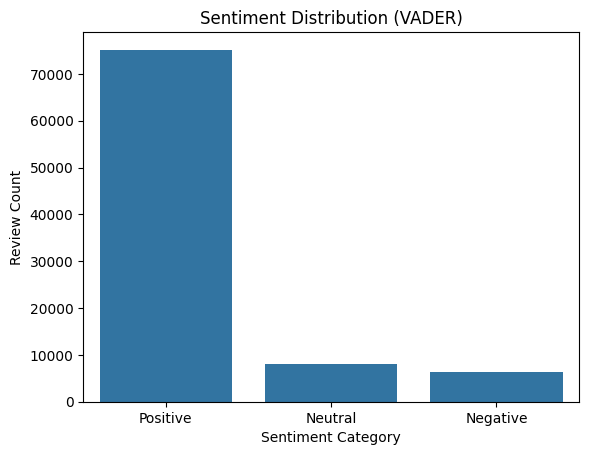

In [ ]:
#1. Sentiment Analysis of Digital Music Product reviews

# Initialize VADER analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# --- VADER Sentiment ---
def get_vader_sentiment(text):
    score = vader_analyzer.polarity_scores(text)
    return score['compound']  # Returns value between -1 (neg) and +1 (pos)

# Too much data to include all of the years, so let's only look at recent reviews (2015 and later)
nlp_df= merged_data[merged_data['timestamp'].dt.year >= 2015]

nlp_df['vader_sentiment_text'] = nlp_df['text'].apply(get_vader_sentiment)
nlp_df['vader_sentiment_title'] = nlp_df['title_reviews'].apply(get_vader_sentiment)

# Categorize into Positive, Neutral, Negative
def categorize_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

nlp_df['sentiment_category_text'] = nlp_df['vader_sentiment_text'].apply(categorize_sentiment)

# Preview result
print(nlp_df[['text', 'vader_sentiment_text','vader_sentiment_title', 'sentiment_category_text']].tail())

sns.countplot(data=nlp_df, x='sentiment_category_text')
plt.title("Sentiment Distribution (VADER)")
plt.xlabel("Sentiment Category")
plt.ylabel("Review Count")
plt.show()

The sentiment analysis is significantly positive .

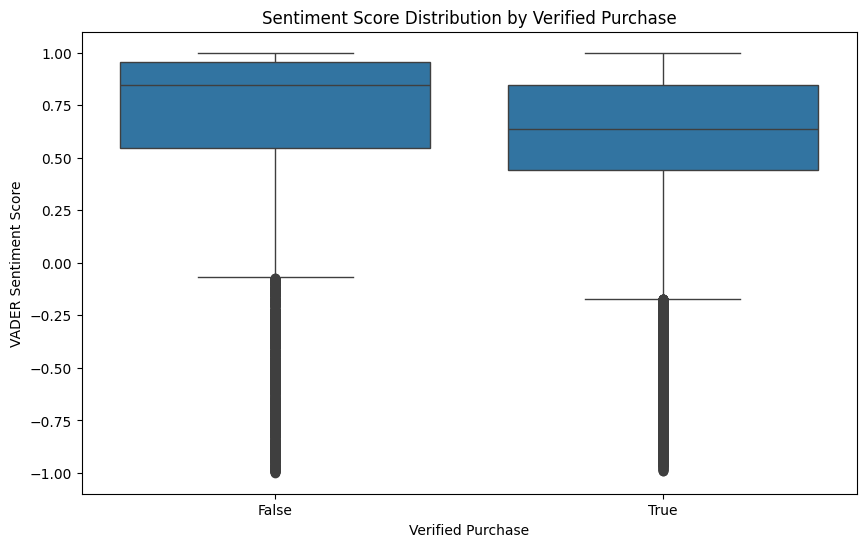

In [ ]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=nlp_df, x='verified_purchase', y='vader_sentiment_text')
plt.title("Sentiment Score Distribution by Verified Purchase")
plt.xlabel("Verified Purchase")
plt.ylabel("VADER Sentiment Score")
plt.show()

Non-verified product reviews are more positive than verfied purchases.However the non-verified reviews do not have have negativite or fake-looking sentiment patterns. Hence there is not clear difference in emotional tone. Hence we can continue to keep this feature and not filter to verified purchase only.

In [ ]:
# 2. Topic Modeling to identify common themes or topics in user reviews

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Preprocessing function
def preprocess(text):
    # Convert to lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # remove words which common HTML artifacts from user-generated content
    custom_stopwords = set(stopwords.words('english')).union({"br", "quot", "amp", "nbsp"})

    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stopwords]
    return tokens

# Apply preprocessing to the review text
# Using the 'text' column from the merged_data DataFrame
processed_reviews = nlp_df['text'].apply(preprocess)

# Convert processed tokens back to string
docs = [" ".join(tokens) for tokens in processed_reviews]

# Vectorize
vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english')
X = vectorizer.fit_transform(docs)

# Train LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Show topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_terms = [terms[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx + 1}: {' | '.join(top_terms)}")


Topic 1: loved | condition | came | songs | music | good | album | love | great | cd
Topic 2: sound | wonderful | songs | voice | beautiful | recording | excellent | love | great | music
Topic 3: guitar | time | best | rock | songs | song | music | band | like | album
Topic 4: concerto | recordings | like | la | symphony | cd | asin | orchestra | recording | music
Topic 5: tracks | original | quality | set | like | good | songs | album | sound | cd


Average VADER Sentiment Score by Rating:


,rating,vader_sentiment_text
0,1.0,-0.072823
1,2.0,0.097823
2,3.0,0.313443
3,4.0,0.566848
4,5.0,0.639834


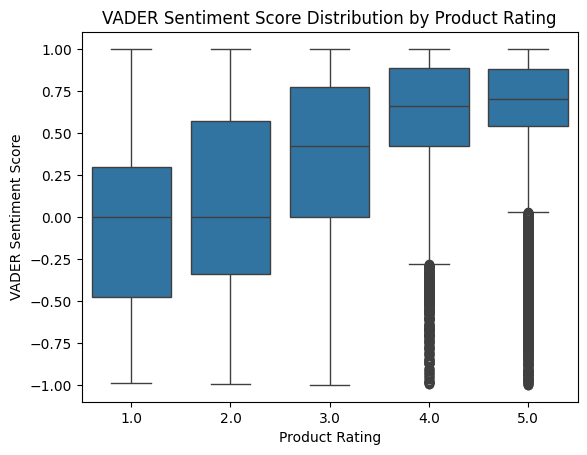

In [ ]:
# 3. Compare sentiment scores with Rating

# Group by rating and calculate the mean VADER sentiment score
sentiment_by_rating = nlp_df.groupby('rating')['vader_sentiment_text'].mean().reset_index()

print("Average VADER Sentiment Score by Rating:")
display(sentiment_by_rating)

# visualize this relationship with a box plot or scatter plot
sns.boxplot(data=nlp_df, x='rating', y='vader_sentiment_text')
plt.title("VADER Sentiment Score Distribution by Product Rating")
plt.xlabel("Product Rating")
plt.ylabel("VADER Sentiment Score")
plt.show()



Sentiment Category Counts by Rating:


sentiment_category_text,Negative,Neutral,Positive
rating,,,
1.0,2149,903,1405
2.0,778,345,974
3.0,892,479,2570
4.0,564,622,6814
5.0,1946,5773,63412


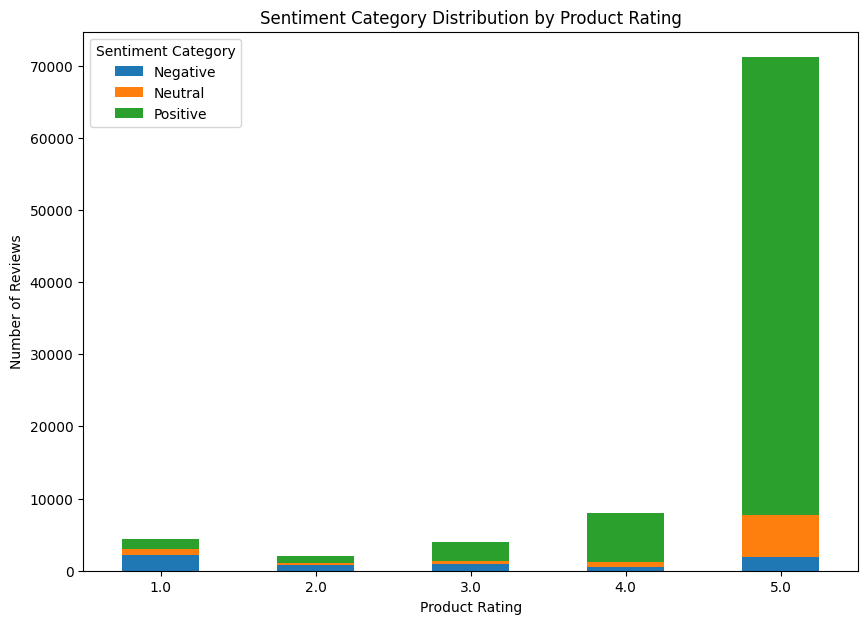

In [ ]:
# Count the occurrences of each sentiment category per rating
sentiment_category_counts = nlp_df.groupby('rating')['sentiment_category_text'].value_counts().unstack(fill_value=0)

print("Sentiment Category Counts by Rating:")
display(sentiment_category_counts)

# visualize this with a stacked bar chart
sentiment_category_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title("Sentiment Category Distribution by Product Rating")
plt.xlabel("Product Rating")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Sentiment Category")
plt.show()

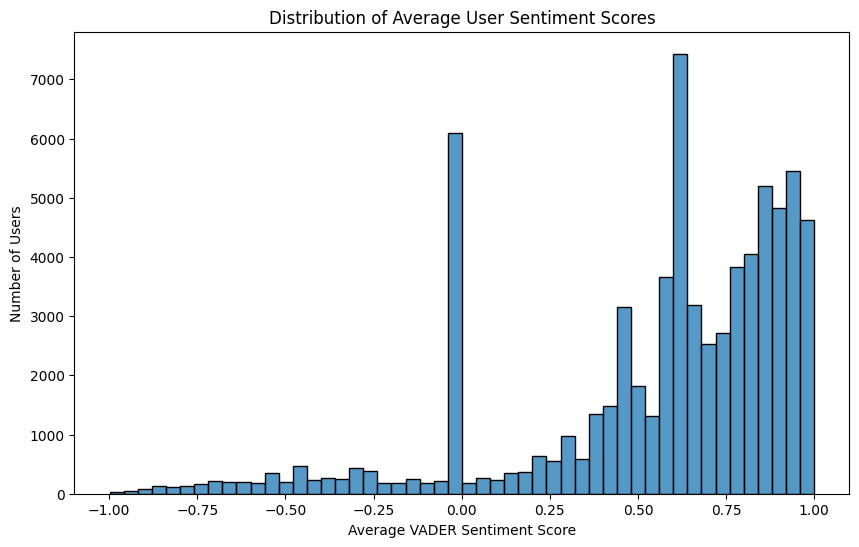

In [ ]:
# 4. User Profiling & Behavior Insights of users based on their review sentiments.
# Calculate the average sentiment score for each user
user_sentiment = nlp_df.groupby('user_id')['vader_sentiment_text'].mean().reset_index()

# distribution of these average scores
plt.figure(figsize=(10, 6))
sns.histplot(user_sentiment['vader_sentiment_text'], bins=50)
plt.title("Distribution of Average User Sentiment Scores")
plt.xlabel("Average VADER Sentiment Score")
plt.ylabel("Number of Users")
plt.show()

Average VADER Sentiment Score by Year:


,year,vader_sentiment_text
0,2015,0.595683
1,2016,0.584070
2,2017,0.575144
3,2018,0.573787
4,2019,0.569765
5,2020,0.567863
6,2021,0.565556
7,2022,0.535378
8,2023,0.516712


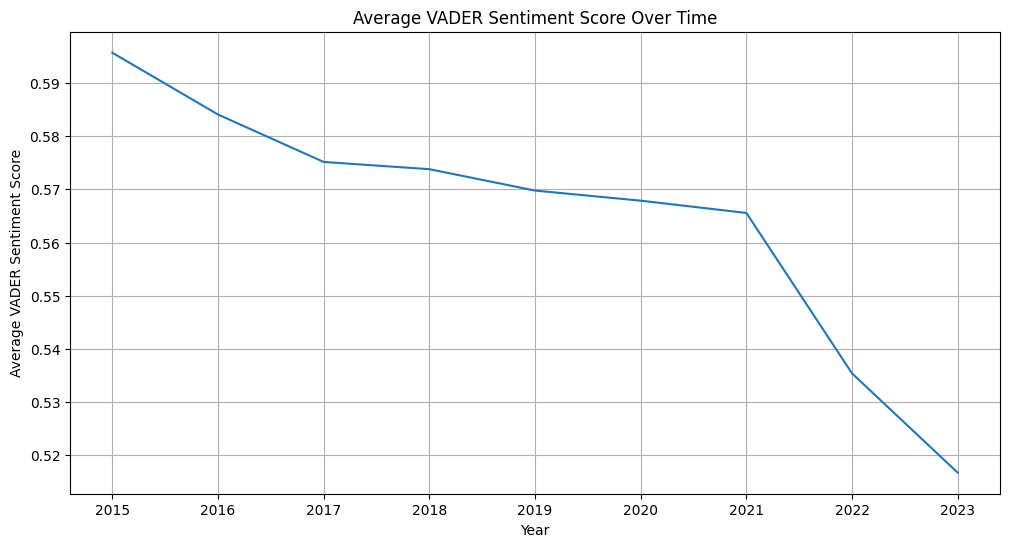

In [ ]:
# 5. Review Trend Analysis: Sentiment over time

# Extract the year from the timestamp
nlp_df['year'] = nlp_df['timestamp'].dt.year

# Calculate the average sentiment score per year
sentiment_by_year = nlp_df.groupby('year')['vader_sentiment_text'].mean().reset_index()

print("Average VADER Sentiment Score by Year:")
display(sentiment_by_year)

# Visualize the sentiment trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_by_year, x='year', y='vader_sentiment_text')
plt.title("Average VADER Sentiment Score Over Time")
plt.xlabel("Year")
plt.ylabel("Average VADER Sentiment Score")
plt.grid(True)
plt.show()

In [ ]:
# Review Trend Analysis: Keyword usage over time

from collections import Counter

# Function to get most common words for a given year
def get_most_common_words_by_year(df, year, num_words=10):
    # Filter reviews for the specific year
    reviews_in_year = df[df['year'] == year]['text']
    # Preprocess the text and flatten the list of tokens
    all_tokens = [word for review in reviews_in_year for word in preprocess(review)]
    # Count word frequencies
    word_counts = Counter(all_tokens)
    # Get the most common words
    return word_counts.most_common(num_words)

# Example: Get most common words for a few recent years
years_to_analyze = sorted(nlp_df['year'].unique(), reverse=True)[:5] # Get last 5 years with reviews

print("Most common words in reviews by year:")
for year in years_to_analyze:
    most_common = get_most_common_words_by_year(nlp_df, year)
    print(f"\nYear {year}:")
    for word, count in most_common:
        print(f"- {word} ({count})")

Most common words in reviews by year:

Year 2023:
- cd (1292)
- great (902)
- music (862)
- album (702)
- one (597)
- love (545)
- songs (538)
- good (507)
- like (464)
- time (289)

Year 2022:
- cd (2953)
- great (2285)
- music (2193)
- album (2047)
- love (1537)
- one (1527)
- songs (1512)
- good (1306)
- like (1276)
- sound (804)

Year 2021:
- cd (3395)
- great (2797)
- album (2735)
- music (2699)
- love (1910)
- one (1800)
- songs (1717)
- good (1618)
- like (1543)
- sound (921)

Year 2020:
- cd (2471)
- album (2335)
- music (2171)
- great (2167)
- one (1609)
- love (1578)
- good (1331)
- like (1305)
- songs (1279)
- sound (933)

Year 2019:
- cd (2744)
- great (2530)
- album (2370)
- music (2234)
- love (1855)
- one (1677)
- good (1523)
- songs (1374)
- like (1323)
- sound (935)


Product Centrality Measures with Average Sentiment:


,title_meta,Degree,Weighted Degree,Betweenness,Closeness,Eigenvector,vader_sentiment_text
0,Kid's Praise! 1 - A Explosion of Happiness - The Kid's Praise Album,0.04,4,0.0,0.04,6.875950e-09,0.755770
1,Psalty Kid's Praise! 2 - Joyfulliest Noise,0.04,4,0.0,0.04,6.875950e-09,0.628568
2,THE BEATLES THE RIVER RHINE TAPES CD MINI LP OBI,0.04,6,0.0,0.04,6.875950e-09,0.467333
3,THE BEATLES FINAL RIVER RHINE TAPES CD MINI LP OBI,0.04,6,0.0,0.04,6.875950e-09,0.573443
4,Sounds of the Seventies: 1975,0.08,8,0.0,0.08,5.773503e-01,0.661314


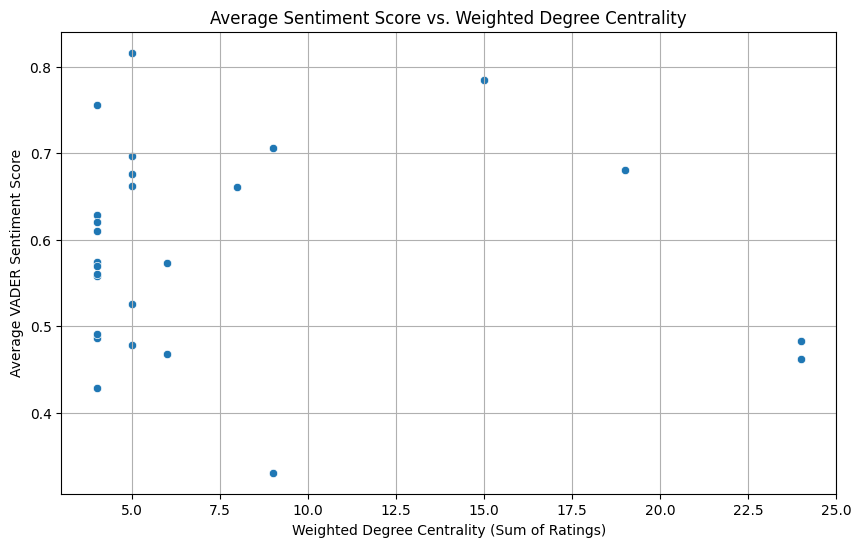

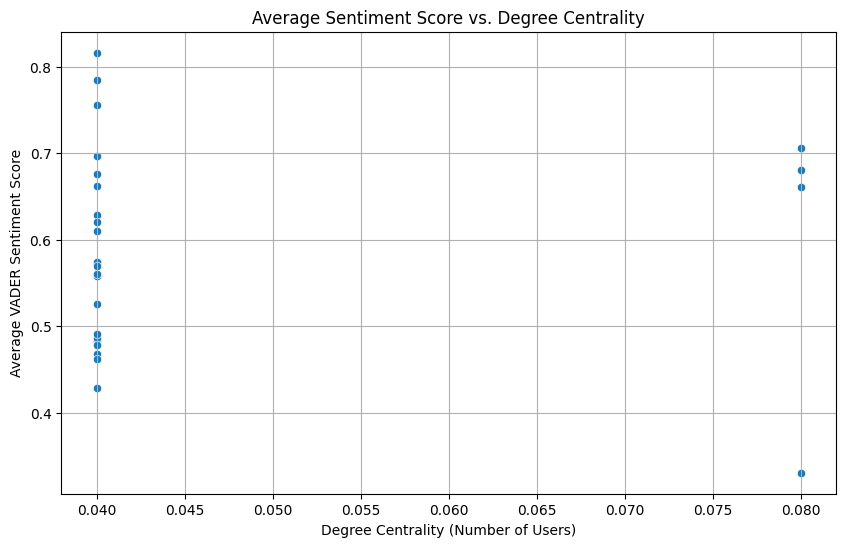


Correlation Matrix: Average Sentiment vs. Centrality Measures


,vader_sentiment_text,Degree,Weighted Degree,Betweenness,Closeness,Eigenvector
vader_sentiment_text,1.000000,0.024942,-0.079172,0.160835,0.081153,-0.068628
Degree,0.024942,1.000000,0.272386,0.469042,0.969697,0.847010
Weighted Degree,-0.079172,0.272386,1.000000,0.389118,0.296814,0.073410
Betweenness,0.160835,0.469042,0.389118,1.000000,0.454828,-0.072193
Closeness,0.081153,0.969697,0.296814,0.454828,1.000000,0.821353
Eigenvector,-0.068628,0.847010,0.073410,-0.072193,0.821353,1.000000


In [ ]:

# Analyze the relationship between sentiment score and centrality measures

# calculate the average sentiment score for each product from the nlp_df (which is filtered by year >= 2015)
product_avg_sentiment = nlp_df.groupby('title_meta')['vader_sentiment_text'].mean().reset_index()

# Merge centrality measures with average sentiment
# Need to reset index for products_centrality_trimmed to merge on 'title_meta'
products_centrality_sentiment = products_centrality_trimmed.reset_index().rename(columns={'index': 'title_meta'})
products_centrality_sentiment = products_centrality_sentiment.merge(product_avg_sentiment, on='title_meta', how='left')

# Drop rows where sentiment could not be calculated (if any products in the trimmed graph have no reviews in nlp_df)
products_centrality_sentiment.dropna(subset=['vader_sentiment_text'], inplace=True)

print("Product Centrality Measures with Average Sentiment:")
display(products_centrality_sentiment.head())

# Visualize the relationship
# Scatter plot of sentiment vs. Weighted Degree Centrality
plt.figure(figsize=(10, 6))
sns.scatterplot(data=products_centrality_sentiment, x='Weighted Degree', y='vader_sentiment_text')
plt.title("Average Sentiment Score vs. Weighted Degree Centrality")
plt.xlabel("Weighted Degree Centrality (Sum of Ratings)")
plt.ylabel("Average VADER Sentiment Score")
plt.grid(True)
plt.show()

# Scatter plot of sentiment vs. Degree Centrality
plt.figure(figsize=(10, 6))
sns.scatterplot(data=products_centrality_sentiment, x='Degree', y='vader_sentiment_text')
plt.title("Average Sentiment Score vs. Degree Centrality")
plt.xlabel("Degree Centrality (Number of Users)")
plt.ylabel("Average VADER Sentiment Score")
plt.grid(True)
plt.show()


# Calculate the correlation between sentiment and centrality measures
centrality_sentiment_corr = products_centrality_sentiment[['vader_sentiment_text', 'Degree', 'Weighted Degree', 'Betweenness', 'Closeness', 'Eigenvector']].corr()

print("\nCorrelation Matrix: Average Sentiment vs. Centrality Measures")
display(centrality_sentiment_corr)


In [ ]:
# Identify polarizing products (high centrality, low sentiment)

merged_sentiment_centrality = products_centrality_sentiment

# Defining thresholds using centrality metric: Weighted Degree
centrality_threshold = merged_sentiment_centrality['Weighted Degree'].quantile(0.75) # Top 25% in weighted degree
sentiment_threshold = merged_sentiment_centrality['vader_sentiment_text'].quantile(0.25) # Bottom 25% in average sentiment

polarizing_products = merged_sentiment_centrality[
    (merged_sentiment_centrality['Weighted Degree'] >= centrality_threshold) &
    (merged_sentiment_centrality['vader_sentiment_text'] <= sentiment_threshold)
]

print("\nPolarizing Products (High Weighted Degree Centrality, Low Average Sentiment):")
display(polarizing_products[['title_meta', 'Weighted Degree', 'vader_sentiment_text']].sort_values(by='vader_sentiment_text'))

# Defining thresholds using centrality metric: Betweenness
polarizing_products_betweenness = merged_sentiment_centrality[
    (merged_sentiment_centrality['Betweenness'] >= merged_sentiment_centrality['Betweenness'].quantile(0.65)) &
    (merged_sentiment_centrality['vader_sentiment_text'] <= sentiment_threshold)
]

print("\nPolarizing Products (High Betweenness Centrality, Low Average Sentiment):")
display(polarizing_products_betweenness[['title_meta', 'Betweenness', 'vader_sentiment_text']].sort_values(by='vader_sentiment_text'))


Polarizing Products (High Weighted Degree Centrality, Low Average Sentiment):


,title_meta,Weighted Degree,vader_sentiment_text
5,Sounds Of The Seventies - 1971,9,0.330417
8,Anthology 2,24,0.462136
7,Anthology 1,24,0.482681



Polarizing Products (High Betweenness Centrality, Low Average Sentiment):


,title_meta,Betweenness,vader_sentiment_text
5,Sounds Of The Seventies - 1971,0.0,0.330417
9,Second Coming,0.0,0.428779
8,Anthology 2,0.0,0.462136
2,THE BEATLES THE RIVER RHINE TAPES CD MINI LP OBI,0.0,0.467333
21,ATEEZ First Album - Treasure EP.1 : All to Zero CD + Sticker + on Pack Poster + Postcards + Photocards + FREE GIFT / K-POP Sealed,0.0,0.478155
7,Anthology 1,0.0,0.482681
18,Crosby Stills & Nash (CD),0.0,0.486014


#### Finding Similar Products - Content Based Recommendations

To compare against our network analysis recommendations, let's make product recommendations based off of the reviews of each product using NLP.

To do this we will use scikit learn's [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This creates a matrix of TF-IDF features of text, which we can then get the cosine similarity to find the most similar products:.

In [ ]:
# Using NLP for content based recommender
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# We will run out of RAM if we don't trim down the data so only focus on 2019 reviews and later
nlp_tfidf_df = merged_data[["title_meta", "timestamp", "text"]]
nlp_tfidf_df_filtered = nlp_tfidf_df[nlp_tfidf_df['timestamp'].dt.year >= 2019]
num_reviews_df = nlp_tfidf_df_filtered.groupby('title_meta').size()

# Filter our noise and just focus on products with at least 5 reviews
num_reviews_df = num_reviews_df.to_frame(name='count')
min_num_reviews = num_reviews_df[num_reviews_df['count'] > 5]
filtered_product_list = min_num_reviews.index.tolist()
nlp_tfidf_df_filtered_final = nlp_tfidf_df_filtered[nlp_tfidf_df_filtered['title_meta'].isin(filtered_product_list)]

# Group by product, and combine all the reviews into one `text` column
nlp_tfidf_df_filtered_final_grouped = nlp_tfidf_df_filtered_final.groupby('title_meta')['text'].agg(list)
nlp_tfidf_df_filtered_final_grouped = pd.DataFrame(nlp_tfidf_df_filtered_final_grouped)
nlp_tfidf_df_filtered_final_grouped['text'] = nlp_tfidf_df_filtered_final_grouped['text'].str.join(', ')
nlp_tfidf_df_filtered_final_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 938 entries,  to … And Justice For All (CD)
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    938 non-null    object
dtypes: object(1)
memory usage: 14.7+ KB


In [ ]:
# Preview the input data -- needed to combine all the reviews into one `text` for each album
nlp_tfidf_df_filtered_final_grouped.head()

,text
title_meta,
,"The music had a nice vibe throughout the whole show with some bantering with the crowd.One could assume the band was in a great altered state of mind along with the crowd ✌️, An outstanding performance., Hearing this album again takes me back to being in 6th grade and seeing my first picture of The Beatles. Oh those were the days!, The seller was very careful and precise and helpful in placing this order. The CD arrived in excellent condition and in a timely manner. I am enjoying this CD. It is uplifting and inspirational. Thank you., An amazing album from Super Junior’s main vocalist, Yesung., You know the story, but you've never heard it the way Al and Wendy tell it!, Arrived more than a week early and was exactly as described."
(REISSUE!!)DICON VOL.10 Official Authentic ISSUE10 BTS goes on Dispatch Magazine [ FULL GROUP Edition ] (Language:English) K-POP SEALED + TRACKING CODE,"I love this magazine/book! The package came secure and perfect!, [[VIDEOID:9a8e90739122a83d975955e20f9adcb5]] Theres more stuff than in my pics but i just selected the ones that show a good overview. Everything came in the package that is listed in the description. And nothing was damaged. It came early as well which was a nice surprise. Im a collector and show everything on my merch Instagram for bts/bt21 if you are interested i try to tell where i get everything from as well so u could find this post pretty easily. @mallycat_bts_luvr4lyf, Absolutely love this. Very detailed even came with a free card, shipping was super fast. Great seller., It is everything beautiful!, I ordered this a few days ago, and delivery date was supposed to be 2+ weeks from the order date, but I got it today! I was so excited - thank you :) Everything was very well wrapped in bubble-wrap, so nothing was damaged. Perfect condition!<br /><br />I didn't even realize the order included so many posters. I first thought it was just headshots but then it kept unrolling into a beautiful long poster?! And there were 8 of them? I love them, the photo book, and the calendar :)<br /><br />Thank you so much!, Everything arrived as described and well packaged! I upgraded the shipping and it arrived within a few days! Highly recommend and would buy from again!, Thank you for the product. They came sooner than expected. They're very well packaged. No damage. Thank you so much. As always please stay safe, healthy and happy., I was amazed at the quality and beauty of the pictures.. Definitely worth the investment!!!, Arrived quickly, well packaged, item was brand new & in perfect condition. Thank you!, I would buy this item again and again and again, It was so amazing<br />And so fast shipping"
+ (Plus) and ÷ (Divide) - Ed Sheeran Greatest Hits 2 CD Album Bundling,"I love Ed Sheeran's music. He's a wonderful singer and does a great job telling the story. I have most of his CDs. I love all his songs. Wonderful albums., Great item. arrived quickly, Love the cd's., If you’ve listened to Ed Sheeran a little or a lot, this compilation is a must. Using a cd makes it much easier to take and provide enjoyment for a group. If you’re like me, it’s easier because your guest may not have a speaker. I happen to really like Ed Sheeran, so I’m very happy this seller had this set available., They were both ok., So enjoyable, I received the product I ordered it was in good condition when I received it., Wonderful CD set great music, Sturdy and sounds good, Ed Sheeran always great! Sound was terrific. No skips (hate that). Will enjoy over and over. 😉, SO GLAD TO FINALLY HAVE MY OWN COLLECTION OF ED SHEERAN!, Great music if your an Ed Sheeran fan., To play my CD in my vehicle while driving, I liked my CD’s and got them quickly, thanks! I wanted CD , Surfing by the Ventures but it was sold out. When you get it back in stock send me one or let me know, Disc cover was busted up to the point of unusable upon arrival, Only wanted1cd, I am not familiar with all his songs., The CDs were great and

In [ ]:
# Create TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=6000)

# Create features matrix
tdidf_matrix = tfidf.fit_transform(nlp_tfidf_df_filtered_final_grouped['text'])

print("Inspect the features created (showing top 20):")
print(tfidf.get_feature_names_out()[:20])

# Create a data frame based off our matrix data and set the index to be the product name
tfidf_summary_df = pd.DataFrame(tdidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_summary_df.index = nlp_tfidf_df_filtered_final_grouped.index

# Find the cosine similaraity of each pair of products and create a data frame
cosine_similarity_array = cosine_similarity(tfidf_summary_df)
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=tfidf_summary_df.index, columns=tfidf_summary_df.index)

Inspect the features created (showing top 20):
['00' '000' '01' '03' '04' '05' '06' '08' '09' '10' '100' '10th' '11'
 '11th' '12' '13' '13th' '14' '15' '16']


In [ ]:
def content_based_recommend(title, top_n = 10):
  '''
  Provide top n product recommendations given a product name
  '''
  # Grab the similarities for product title
  cos_sim = cosine_similarity_df.loc[title]
  # Sort the recommended products by cosine similarity socore
  product_recs_sorted = cos_sim.sort_values(ascending=False)[1:top_n]
  return product_recs_sorted

test_title = 'Anthology 2'
print(f"Recommendations for {test_title}:")
print(content_based_recommend(test_title))

Recommendations for Anthology 2:
title_meta
Anthology 1                                                        0.592887
The Beatles: 1962-1966 (The Red Album) (2CD)                       0.487334
1 (Remixed And Remastered) [CD]                                    0.373672
THE BEATLES - HELP! IN CONCERT: GREATEST HITS 1964-'66-4 CD SET    0.370121
Abbey Road (50th Anniversary Edition) (CD)                         0.329831
The Beatles: Rubber Soul in Mono (180g) Vinyl LP                   0.275572
Lennon Legend: The Very Best of John Lennon                        0.254174
Greatest Hits                                                      0.251642
Complete Star Club Tapes 1962                                      0.246599
Name: Anthology 2, dtype: float64


`Anthology 1` is the top recommendation (most similar product) which matches our output for our network analysis recommender. It makes sense that all of the recommendations are related to The Beatles albums, specifically their greatest hits. If a custmer purchases `Anthology 2`, it would make sense for Amazon to list the above albums as recommend products based off of similarity.

The benefit of using NLP for a recommender is that we now see the other most similar products based off user reviews. Creating recommendations based off shared nodes in a network did not give as many product options. Although network analysis helps us visualize unexpected purchasing trends and clusters within Amazon, it might not be used as the best overall recommender compared to NLP.

## Summary for Digital Music Amazon products, users and its reviews

*   **EDA Analysis:**

*   The data set there were a total of 130434 reviews that included 100952 uniques users and 70511 unique products.
*   The average number of reviews a user posted (130,434/100,952 is 1.29 indicating that few users reviewed multiple products.
*   The average number of reviews for each product is (130,434 / 70,511) is 1.85 indicating that almost all products were reviewed by multiple users.
*   Reviews were made between the years 1997 - 2023 with 2015 being the year with the most reviews.
*   The product ratings were heavily skewed to the the left indicating most products in the data set had a rating of 4 or higher (max of 5)
*   The number of raw characters in each review ranged from 0 - 24366 characters.
*   The number of words in each review ranged from 0 - 4187.


*   **Network Analysis:**

*   User trimmed network via island method: 18 nodes, 6 connected components.
  *   The maximum amount of nodes for the largest connected component was 6 nodes.
  *   In total, 7 communities were found.
  *  Within the trimmed network user 3155 had the highest degree centrality. Indicating this user has rated a lot of music, and may be important in getting other users to rate music. Hence the most influential and central user in the network.
  *  Other top users, such as 49031, are also highly connected and influential, though their positions within the network are slightly more localized. These users likely represent highly active raters with broadly overlapping music preferences, making them ideal anchors for collaborative filtering or influence propagation studies.
  * This analysis showed that top users have similar co purchasing behavior
*   Music trimmed network via island method: 26 nodes, 12 connected components.
  *   The maximum amount of nodes for the largest connected component was 3 nodes.
  *   In total, 12 communities were found. Many consisted of a part 1 and 2 of an album series (many being "greatest hits" albums).
  *  Within the trimmed network, `Anthology 1` had the highest degree centrality. This means that it is a popular or mainstream album that many people have rated. Although, their lower eigenvector score suggests they are not connected to other influential albums. `Time Life Sounds of the Seventies: 1973` had the highest eigenvector score.
  *  Community 1 (`Sounds Of The Seventies`) dominated most of the average centrality metrics except for betweeness centrality, which Community 2 (`Elvis`) had the highest.
  * Looking at the descriptions for each album within the communities, we can see that all the products come from the same artist, or if from multiple artists, same genre/time period.


*   **Sentiment Analysis:** The overall sentiment of the reviews is mostly positive.This is typical of Amazon reviews where 4/5-star ratings dominate.The relationship between sentiment scores and ratings in coherent as better ratings had better sentiment scores, and verified vs non verified purchase status did not matter in review sentiments.
*   **Topic Modeling:** 5 topics were generated. Sound and music was common among most of the topics.
*   **User Profiling:** There are 3 user clusters observed based on the sentiment score.
*   **Trend Analysis:** The sentiment score reduced over the years.The common words used in reviews across 5 years are consistent.
*   **Sentiment score and centrality measures:** Based on weighted Degree Centrality, most products cluster at low weighted degree and their sentiment scores are generally moderately positive. A few products with high weighted centrality (e.g., 15-24) show mixed sentiment.
*   **Correlation** There is weak or no correlation between centrality and sentiment.Thus popularity in the co-purchase network doesn't strongly predict how positive the reviews are.
*   **Polarizing Products (High Weighted Degree Centrality, Low Average Sentiment)**  Products like Anthology 1 & 2, Sounds Of The Seventies - 1971 appear in many co-purchase relationships, indicating wide popularity. However sentiment scores are among the lowest 25%, meaning poor experience and negative emotions.
*   **Product recommender system** To compare our network and NLP analyses, we created a product recommeder model for each. The network model used shared nodes as a similarity score, and the NLP used the combined review text for each album. Both models produced the same recommendation for `Anthology 2`, although the NLP model was unsurprisingly able to produce more recommendations.
